In [1]:
! pip install --upgrade ultralytics 
!pip install --upgrade -U ray[tune]
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 19.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 MB 24.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ray
    Found existing installation: ray 2.24.0
    Uninstalling ray-2.24.0:
      Successfully uninstalled ray-2.24.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 59.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: i

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
from IPython.display import Image, display
import cv2

from ultralytics import YOLO

%matplotlib inline

! wandb disabled

W&B disabled.


In [13]:
class CFG:
    DEBUG = False # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    # classes
    CLASSES = ['door', 'openedDoor', 'cabinetDoor', 'refrigeratorDoor',
               'window', 'chair', 'table',
               'cabinet', 'sofa/couch', 'pole']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 100
    BATCH_SIZE = 16
    
    BASE_MODEL = 'yolov8s' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-4
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.1
    PATIENCE = 30
    PROFILE = False
    LABEL_SMOOTHING = 0.1    

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/indoor-object-detection/'
    OUTPUT_DIR = '/kaggle/working/'

The Ultralytics YOLO format is a dataset configuration format that allows you to define the dataset root directory, the relative paths to training/validation/testing image directories or *.txt files containing image paths, and a dictionary of class names.

In [4]:
# Create data.yaml file properly formatted to be used by Yolo
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [5]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- door
- openedDoor
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- sofa/couch
- pole
nc: 10
test: /kaggle/input/indoor-object-detection/test
train: /kaggle/input/indoor-object-detection/train
val: /kaggle/input/indoor-object-detection/valid



In [54]:
# Visualize one image
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (768, 1024, 3) 



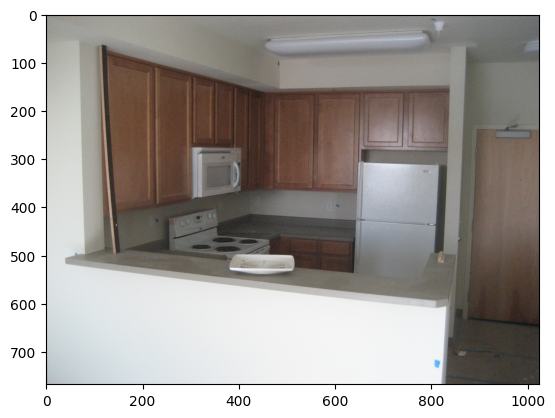

In [7]:
example_image_path = CFG.CUSTOM_DATASET_DIR + '/train/images/01b8f3f2d2cf7613.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

In [9]:
# visualize random images from train set
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

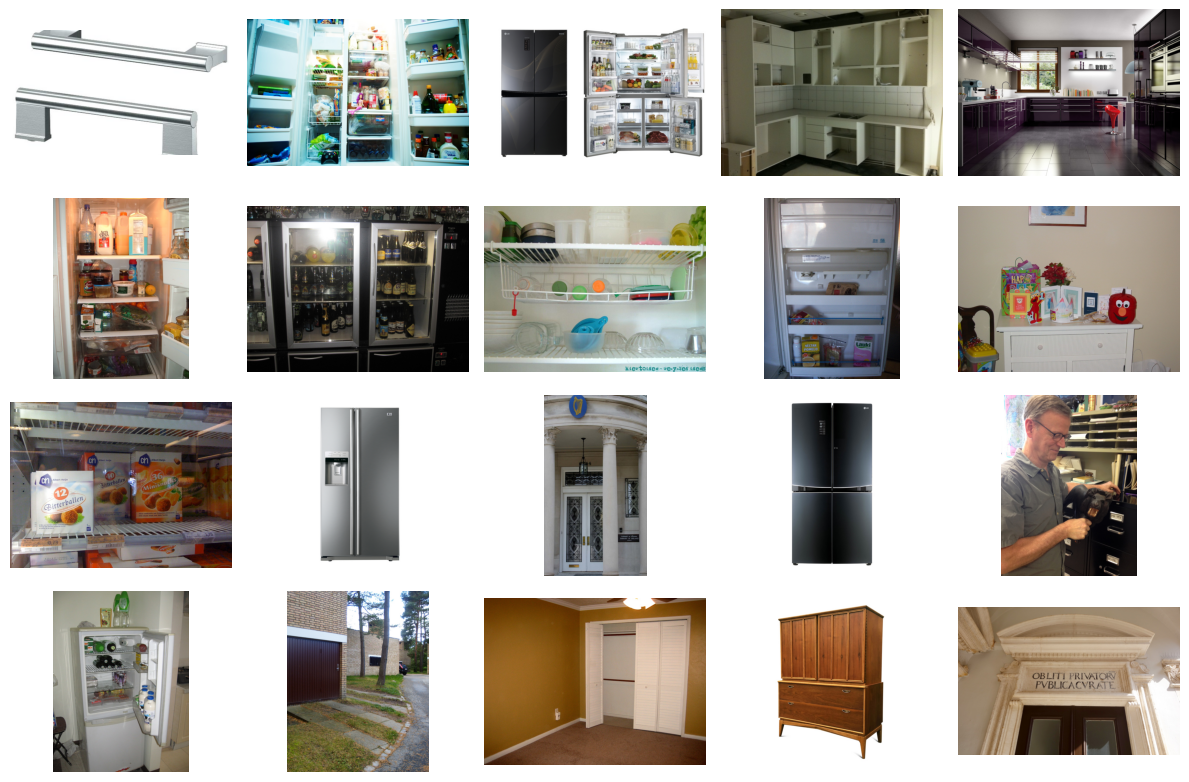

In [10]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

In [10]:
# image properties
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [11]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 1024, 'height': 768, 'channels': 3, 'dtype': dtype('uint8')}

In [10]:
# dataset statistics
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None): 
    display(dataset_stats_df)


Mode  door  openedDoor  cabinetDoor  refrigeratorDoor  window  chair  \
0  train   309         448          332               187     105    165   
1  valid    63          99           85                39      24     30   
2   test    25          42            1                49      38     41   

   table  cabinet  sofa/couch  pole  Data_Volume  
0    138       22          68    14         1008  
1     28        1          13     4          230  
2     44       31          18     3          104

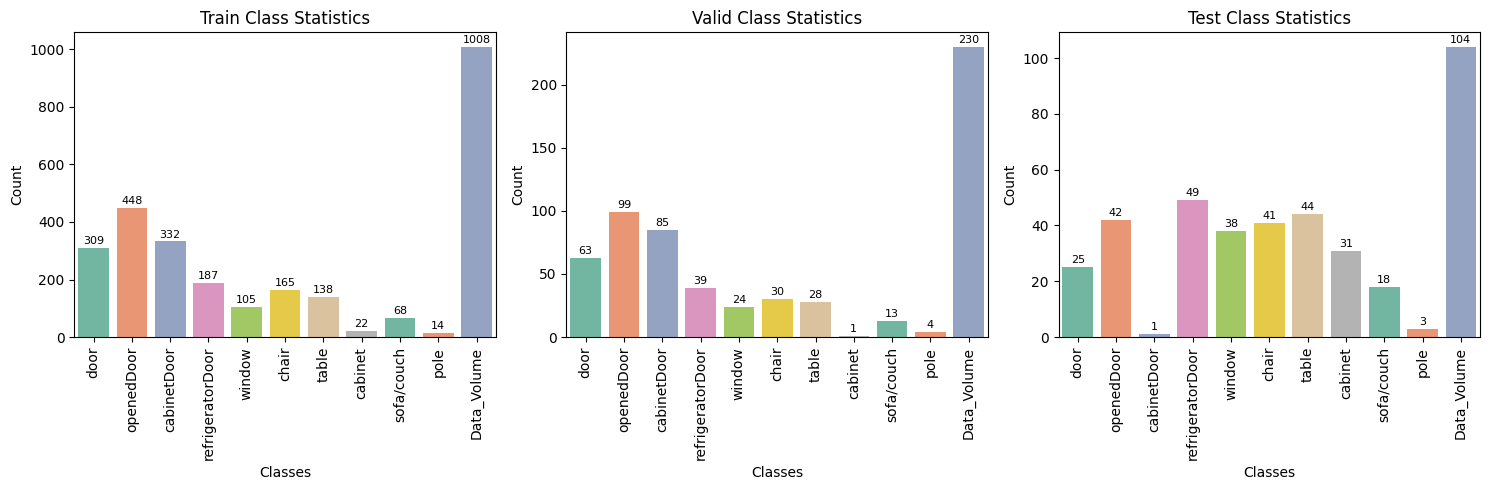

In [14]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

Датасет невеликий із нерівномірним розподілом за класами. Потенційні проблеми з класами, що погано представлені в тестовому наборі, але мають об'єкти в тестовому наборі, наприклад, cabinet. 

In [10]:
# Checking the power of the pretrained model inference on the dataset
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    #classes = range(0,100),
    conf = 0.30,
#     device = [0,1], # inference with dual GPU
    device = None, # inference with CPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

100%|██████████| 14.7M/14.7M [00:00<00:00, 106MB/s] 



image 1/1 /kaggle/input/indoor-object-detection/train/images/01b8f3f2d2cf7613.jpg: 768x1024 1 microwave, 1 oven, 1 refrigerator, 17.9ms
Speed: 8.8ms preprocess, 17.9ms inference, 234.5ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (768, 1024, 3) 



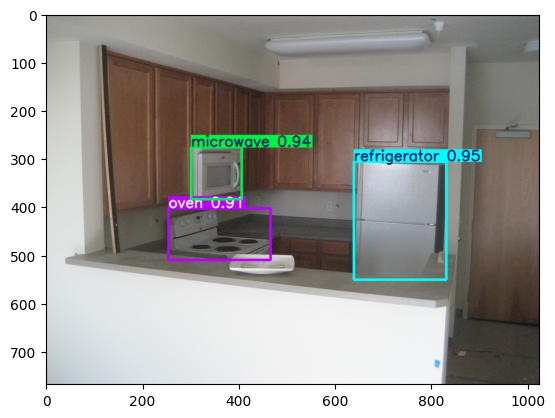

In [16]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

Натренована модель ідентифікує побутову техніку, але не ідентифікує двері, хоча цей клас є в її списку прогнозованих класів. Для подальшого тренування було обрано модель Yolo8 short, хоча проекспериментовано з іншими за розміром Yolo8 та Yolo9. Більш проста модель демонструвала коащі метрики на наших даних. Для боротьби із незбалансованістю класів додано прийоми аугментації даних, як mosaic(4 зображення комбінуються в одне мозаїчне), mixup(лінійна комбінація 2 зображень), copy-paste (об'єкти з одного зображення копіюються до іншого). Розмір зображень зменшено до 640*640.

Для зменшення  перенавчання, до якого дуже схильна модель, було заморожено перші 4 шари моделі та додано дропаут, label smoothing.

In [14]:
### print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8s.pt
Epochs:  100
Batch:  16


In [15]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

100%|██████████| 21.5M/21.5M [00:00<00:00, 243MB/s]


In [16]:
%%time

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = 640, # resize images to 640*640 
    # Augmentation parameters
    #degrees=5.0,
    #translate=0.1,
    #scale=0.5,
    #shear=2.0,
    #perspective=0.0,
    #flipud=0.0,
    #fliplr=0.5,
    mosaic=0.5,
    mixup=0.2,
    #hsv_h=0.015,
    #hsv_s=0.2,
    #hsv_v=0.2,
    copy_paste=0.5,
    
    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,
    
    freeze=[0, 1, 2, 3],
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = [0], 
#     device = None, # CPU run
    verbose = False,
)

Ultralytics YOLOv8.2.98 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov8s_ppe_css_100_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2, 3], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

train: Scanning /kaggle/input/indoor-object-detection/train/labels... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:01<00:00, 987.82it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<00:00, 783.95it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.
Plotting labels to runs/detect/yolov8s_ppe_css_100_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8s_ppe_css_100_epochs
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.86G      1.824      3.147      1.628         46        640: 100%|██████████| 64/64 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.84it/s]

                   all        230       1289      0.383      0.278      0.258      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       3.1G       1.65      2.163      1.476         57        640: 100%|██████████| 64/64 [00:15<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        230       1289       0.42      0.272      0.214      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.15G      1.601      2.074      1.468         49        640: 100%|██████████| 64/64 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.18it/s]

                   all        230       1289      0.481       0.24      0.191      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.16G      1.611      2.001      1.472         28        640: 100%|██████████| 64/64 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

                   all        230       1289      0.371      0.286      0.216      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.92G      1.604      1.947      1.465         37        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]

                   all        230       1289      0.475      0.328      0.281      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       3.1G       1.57      1.902       1.46         27        640: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.44it/s]

                   all        230       1289      0.365      0.425      0.318      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.05G      1.581      1.817      1.453         44        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

                   all        230       1289      0.448      0.239      0.231      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.07G      1.564       1.82      1.452         21        640: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

                   all        230       1289      0.713      0.265      0.289      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.08G      1.544      1.773      1.436         30        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.27it/s]

                   all        230       1289       0.52      0.272      0.298      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.16G      1.526      1.743      1.436         34        640: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.32it/s]

                   all        230       1289      0.438      0.322      0.308      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.14G      1.505      1.645      1.389         47        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        230       1289      0.407      0.305      0.299      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.06G      1.504       1.66      1.413         30        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.37it/s]

                   all        230       1289      0.469      0.326      0.295      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.09G       1.46      1.581      1.376         14        640: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]

                   all        230       1289      0.548      0.342      0.325      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.16G      1.477      1.562      1.375         28        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.27it/s]

                   all        230       1289      0.626      0.294      0.307      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.05G      1.462      1.551      1.389         28        640: 100%|██████████| 64/64 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]

                   all        230       1289      0.514       0.35      0.322      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.16G      1.434      1.526      1.354         15        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]

                   all        230       1289      0.528      0.435      0.434      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.16G      1.451      1.492       1.37         13        640: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]

                   all        230       1289      0.581      0.436      0.391      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.03G      1.444       1.51       1.36         63        640: 100%|██████████| 64/64 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.08it/s]

                   all        230       1289      0.648      0.346      0.373      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.05G      1.426      1.451      1.344         48        640: 100%|██████████| 64/64 [00:15<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]

                   all        230       1289      0.488      0.335      0.368      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.07G      1.406      1.442      1.339         25        640: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]

                   all        230       1289      0.595      0.357      0.366      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.05G      1.401      1.411      1.323         44        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]

                   all        230       1289      0.471       0.38      0.352      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.16G      1.414       1.44      1.348         34        640: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]

                   all        230       1289      0.412      0.476      0.349      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.07G      1.391      1.392       1.32         31        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]

                   all        230       1289      0.395      0.512      0.382      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.13G      1.374      1.358      1.309         26        640: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]

                   all        230       1289      0.421      0.409      0.393      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.06G      1.347      1.298      1.292         44        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]

                   all        230       1289      0.498       0.31      0.359       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.05G      1.392      1.336      1.311         21        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]

                   all        230       1289      0.685      0.332      0.384      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.05G      1.372        1.3      1.311         52        640: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]

                   all        230       1289      0.465       0.43      0.387       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.05G      1.334      1.267      1.295         43        640: 100%|██████████| 64/64 [00:15<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]

                   all        230       1289      0.422      0.383      0.391      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.17G      1.357      1.322      1.312         60        640: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]

                   all        230       1289      0.461      0.398      0.411      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.06G      1.362      1.282      1.299         57        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]

                   all        230       1289      0.378       0.39      0.376      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.07G      1.313      1.194      1.258         18        640: 100%|██████████| 64/64 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]

                   all        230       1289      0.435      0.382      0.409      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.07G      1.305      1.217      1.276         43        640: 100%|██████████| 64/64 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        230       1289      0.363      0.519      0.405      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.06G      1.329      1.234      1.286         69        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]

                   all        230       1289      0.416      0.546      0.496      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.01G      1.282      1.166      1.248         54        640: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]

                   all        230       1289      0.461      0.468      0.494      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.04G      1.266       1.16       1.25         24        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]

                   all        230       1289      0.551      0.496        0.5      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.17G      1.289       1.16      1.267         28        640: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]

                   all        230       1289      0.487      0.466      0.501      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         3G      1.276      1.157      1.252         68        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

                   all        230       1289      0.544      0.396       0.38      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.06G      1.286      1.182      1.262         26        640: 100%|██████████| 64/64 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]

                   all        230       1289      0.471      0.523      0.473      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.04G      1.241      1.155       1.23         22        640: 100%|██████████| 64/64 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        230       1289      0.448      0.412      0.408      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.05G       1.27      1.128      1.244         38        640: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.44it/s]

                   all        230       1289      0.441      0.467      0.436      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.11G      1.256      1.095      1.231         20        640: 100%|██████████| 64/64 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.25it/s]

                   all        230       1289      0.465      0.547      0.457      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.04G      1.253      1.118      1.237         25        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]

                   all        230       1289      0.435       0.45      0.426      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.05G      1.239      1.065      1.225         56        640: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]

                   all        230       1289      0.589      0.375      0.436      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.99G      1.233      1.082      1.223         46        640: 100%|██████████| 64/64 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

                   all        230       1289      0.558      0.504      0.525      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.05G      1.221      1.054      1.209         74        640: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]

                   all        230       1289      0.535      0.488      0.508      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.11G      1.238      1.075      1.226         48        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]

                   all        230       1289      0.521      0.529      0.501      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.06G      1.184      1.018      1.189         29        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]

                   all        230       1289      0.607      0.478      0.476      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.06G      1.191      1.014      1.204         33        640: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]

                   all        230       1289      0.517      0.548      0.489      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       3.1G      1.218      1.019      1.205         49        640: 100%|██████████| 64/64 [00:15<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]

                   all        230       1289      0.566        0.5      0.535      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.05G      1.194      1.021      1.205         88        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]

                   all        230       1289       0.56       0.52      0.473      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.17G      1.186      1.008      1.197         18        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]

                   all        230       1289      0.481      0.407      0.424      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.14G      1.179     0.9833      1.188         31        640: 100%|██████████| 64/64 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.62it/s]

                   all        230       1289      0.504      0.421      0.457      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.13G      1.184     0.9856      1.185         38        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.16it/s]

                   all        230       1289       0.49      0.481      0.458      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.09G      1.184     0.9704      1.192         35        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]

                   all        230       1289      0.614      0.405      0.425      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       3.1G      1.166     0.9683       1.17         38        640: 100%|██████████| 64/64 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]

                   all        230       1289       0.45      0.403      0.425      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.16G      1.155     0.9563       1.18         34        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]

                   all        230       1289       0.67      0.367      0.422      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.98G      1.164     0.9803      1.183         38        640: 100%|██████████| 64/64 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.44it/s]

                   all        230       1289      0.499      0.556      0.524      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.04G      1.143     0.9449      1.169         37        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]

                   all        230       1289      0.474      0.549      0.441       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.09G      1.143     0.9404      1.168         14        640: 100%|██████████| 64/64 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]

                   all        230       1289      0.615      0.372      0.431      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.16G      1.135      0.946      1.166         26        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        230       1289      0.496      0.443      0.427      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.06G      1.124     0.9218      1.174         27        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]

                   all        230       1289      0.486      0.412      0.412      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.06G       1.12     0.9165      1.154         30        640: 100%|██████████| 64/64 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]

                   all        230       1289      0.616      0.383      0.416      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.16G      1.115     0.9306      1.159         49        640: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]

                   all        230       1289      0.511      0.448      0.442      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.03G      1.105     0.9297      1.164         44        640: 100%|██████████| 64/64 [00:15<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]

                   all        230       1289      0.555       0.44      0.426      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.08G      1.133     0.9499      1.173         14        640: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]

                   all        230       1289      0.444      0.512      0.444      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.03G      1.097      0.897      1.149         36        640: 100%|██████████| 64/64 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]

                   all        230       1289      0.445      0.464       0.45       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.98G        1.1     0.8935      1.148         24        640: 100%|██████████| 64/64 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]

                   all        230       1289      0.549        0.5      0.492      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.09G      1.072     0.8468       1.13         24        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

                   all        230       1289      0.619      0.526      0.529      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       3.3G        1.1     0.8666      1.142         56        640: 100%|██████████| 64/64 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]

                   all        230       1289      0.661      0.495      0.529      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.04G      1.083     0.8689      1.141         18        640: 100%|██████████| 64/64 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]

                   all        230       1289       0.44      0.526      0.439      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.16G        1.1     0.8624      1.138         29        640: 100%|██████████| 64/64 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]

                   all        230       1289      0.543      0.436      0.467      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.05G      1.048     0.8362      1.121         34        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]

                   all        230       1289      0.509      0.397      0.431      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.05G      1.064     0.8597       1.13         63        640: 100%|██████████| 64/64 [00:15<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]

                   all        230       1289      0.652      0.456      0.531      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.92G      1.064      0.849      1.129         21        640: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.16it/s]

                   all        230       1289      0.541       0.54      0.545      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.04G      1.051     0.8277      1.116         18        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

                   all        230       1289      0.652      0.403      0.459      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.92G      1.051     0.8247      1.129         12        640: 100%|██████████| 64/64 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]

                   all        230       1289      0.464      0.453      0.439      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.16G      1.049     0.8343      1.121         97        640: 100%|██████████| 64/64 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]

                   all        230       1289      0.472      0.567      0.476       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.05G      1.061     0.8444      1.126         58        640: 100%|██████████| 64/64 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]

                   all        230       1289      0.524      0.541       0.48       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.08G      1.035     0.7981      1.107         43        640: 100%|██████████| 64/64 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]

                   all        230       1289      0.494      0.553      0.472      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.16G      1.007      0.796      1.104          7        640: 100%|██████████| 64/64 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]

                   all        230       1289      0.522      0.508       0.47      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.06G      1.034     0.8197      1.114         69        640: 100%|██████████| 64/64 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]

                   all        230       1289      0.635      0.457      0.531      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.16G      1.036     0.8026      1.107         25        640: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]

                   all        230       1289      0.505      0.549       0.54      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.06G      1.039     0.8121      1.116         31        640: 100%|██████████| 64/64 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]

                   all        230       1289      0.467      0.538      0.468      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.17G      1.054     0.8277      1.124         40        640: 100%|██████████| 64/64 [00:15<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]

                   all        230       1289      0.506      0.558      0.493      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.03G      1.036     0.8346      1.116         16        640: 100%|██████████| 64/64 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]

                   all        230       1289      0.466      0.583      0.479      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.05G      1.004     0.7679      1.093         34        640: 100%|██████████| 64/64 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]

                   all        230       1289      0.573      0.517      0.489      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.15G      0.997     0.7822      1.098         36        640: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]

                   all        230       1289      0.489      0.557      0.482      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.09G     0.9942     0.7467      1.085         57        640: 100%|██████████| 64/64 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]

                   all        230       1289      0.491      0.583      0.479      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.13G      1.006       0.78      1.095         38        640: 100%|██████████| 64/64 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]

                   all        230       1289      0.503      0.552       0.47      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.98G     0.9957     0.7898      1.104          8        640: 100%|██████████| 64/64 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]

                   all        230       1289       0.56      0.512      0.532      0.319


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.98G     0.8096     0.4944     0.9799         20        640: 100%|██████████| 64/64 [00:17<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]

                   all        230       1289       0.53      0.503      0.518      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.16G     0.7998     0.4721     0.9719          7        640: 100%|██████████| 64/64 [00:15<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]

                   all        230       1289       0.53      0.534      0.527      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.98G       0.79      0.465     0.9638          5        640: 100%|██████████| 64/64 [00:15<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]

                   all        230       1289      0.478       0.56      0.531      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.99G     0.7867     0.4603     0.9688         21        640: 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]

                   all        230       1289      0.522      0.524      0.478      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.03G      0.787     0.4557      0.971         21        640: 100%|██████████| 64/64 [00:15<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]

                   all        230       1289      0.524       0.53      0.466      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         3G     0.7701     0.4532     0.9703         27        640: 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]

                   all        230       1289      0.492       0.55      0.462      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.15G     0.7646     0.4472     0.9611         18        640: 100%|██████████| 64/64 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.60it/s]

                   all        230       1289      0.481      0.567      0.468      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.99G     0.7661     0.4409     0.9621         25        640: 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

                   all        230       1289      0.451      0.585      0.455      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.93G     0.7593     0.4401     0.9626         28        640: 100%|██████████| 64/64 [00:15<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]

                   all        230       1289      0.434      0.489      0.455      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.17G     0.7573     0.4362     0.9545         30        640: 100%|██████████| 64/64 [00:15<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]

                   all        230       1289      0.475      0.543      0.466      0.274



100 epochs completed in 0.516 hours.
Optimizer stripped from runs/detect/yolov8s_ppe_css_100_epochs/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_ppe_css_100_epochs/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_ppe_css_100_epochs/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


                   all        230       1289      0.507      0.549       0.54      0.343
Speed: 0.2ms preprocess, 5.5ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to runs/detect/yolov8s_ppe_css_100_epochs
CPU times: user 30min 46s, sys: 1min 25s, total: 32min 12s
Wall time: 31min 22s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f46975c0130>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [17]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = 640, #(img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.98 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs

PyTorch: starting from 'runs/detect/yolov8s_ppe_css_100_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (21.5 MB)

ONNX: starting export with onnx 1.16.2 opset 19...
ONNX: export success ✅ 1.1s, saved as 'runs/detect/yolov8s_ppe_css_100_epochs/weights/best.onnx' (42.7 MB)

Export complete (3.3s)
Results saved to /kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov8s_ppe_css_100_epochs/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/yolov8s_ppe_css_100_epochs/weights/best.onnx imgsz=640 data=/kaggle/working/data.yaml  
Visualize:       https://netron.app


'runs/detect/yolov8s_ppe_css_100_epochs/weights/best.onnx'

In [47]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/R_curve.png',
 '/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/P_curve.png',
 '/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/PR_curve.png',
 '/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/results.png',
 '/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/F1_curve.png',
 '/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/confusion_matrix_normalized.png',
 '/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/confusion_matrix.png',
 '/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/labels_correlogram.jpg',
 '/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/labels.jpg']

/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/F1_curve.png


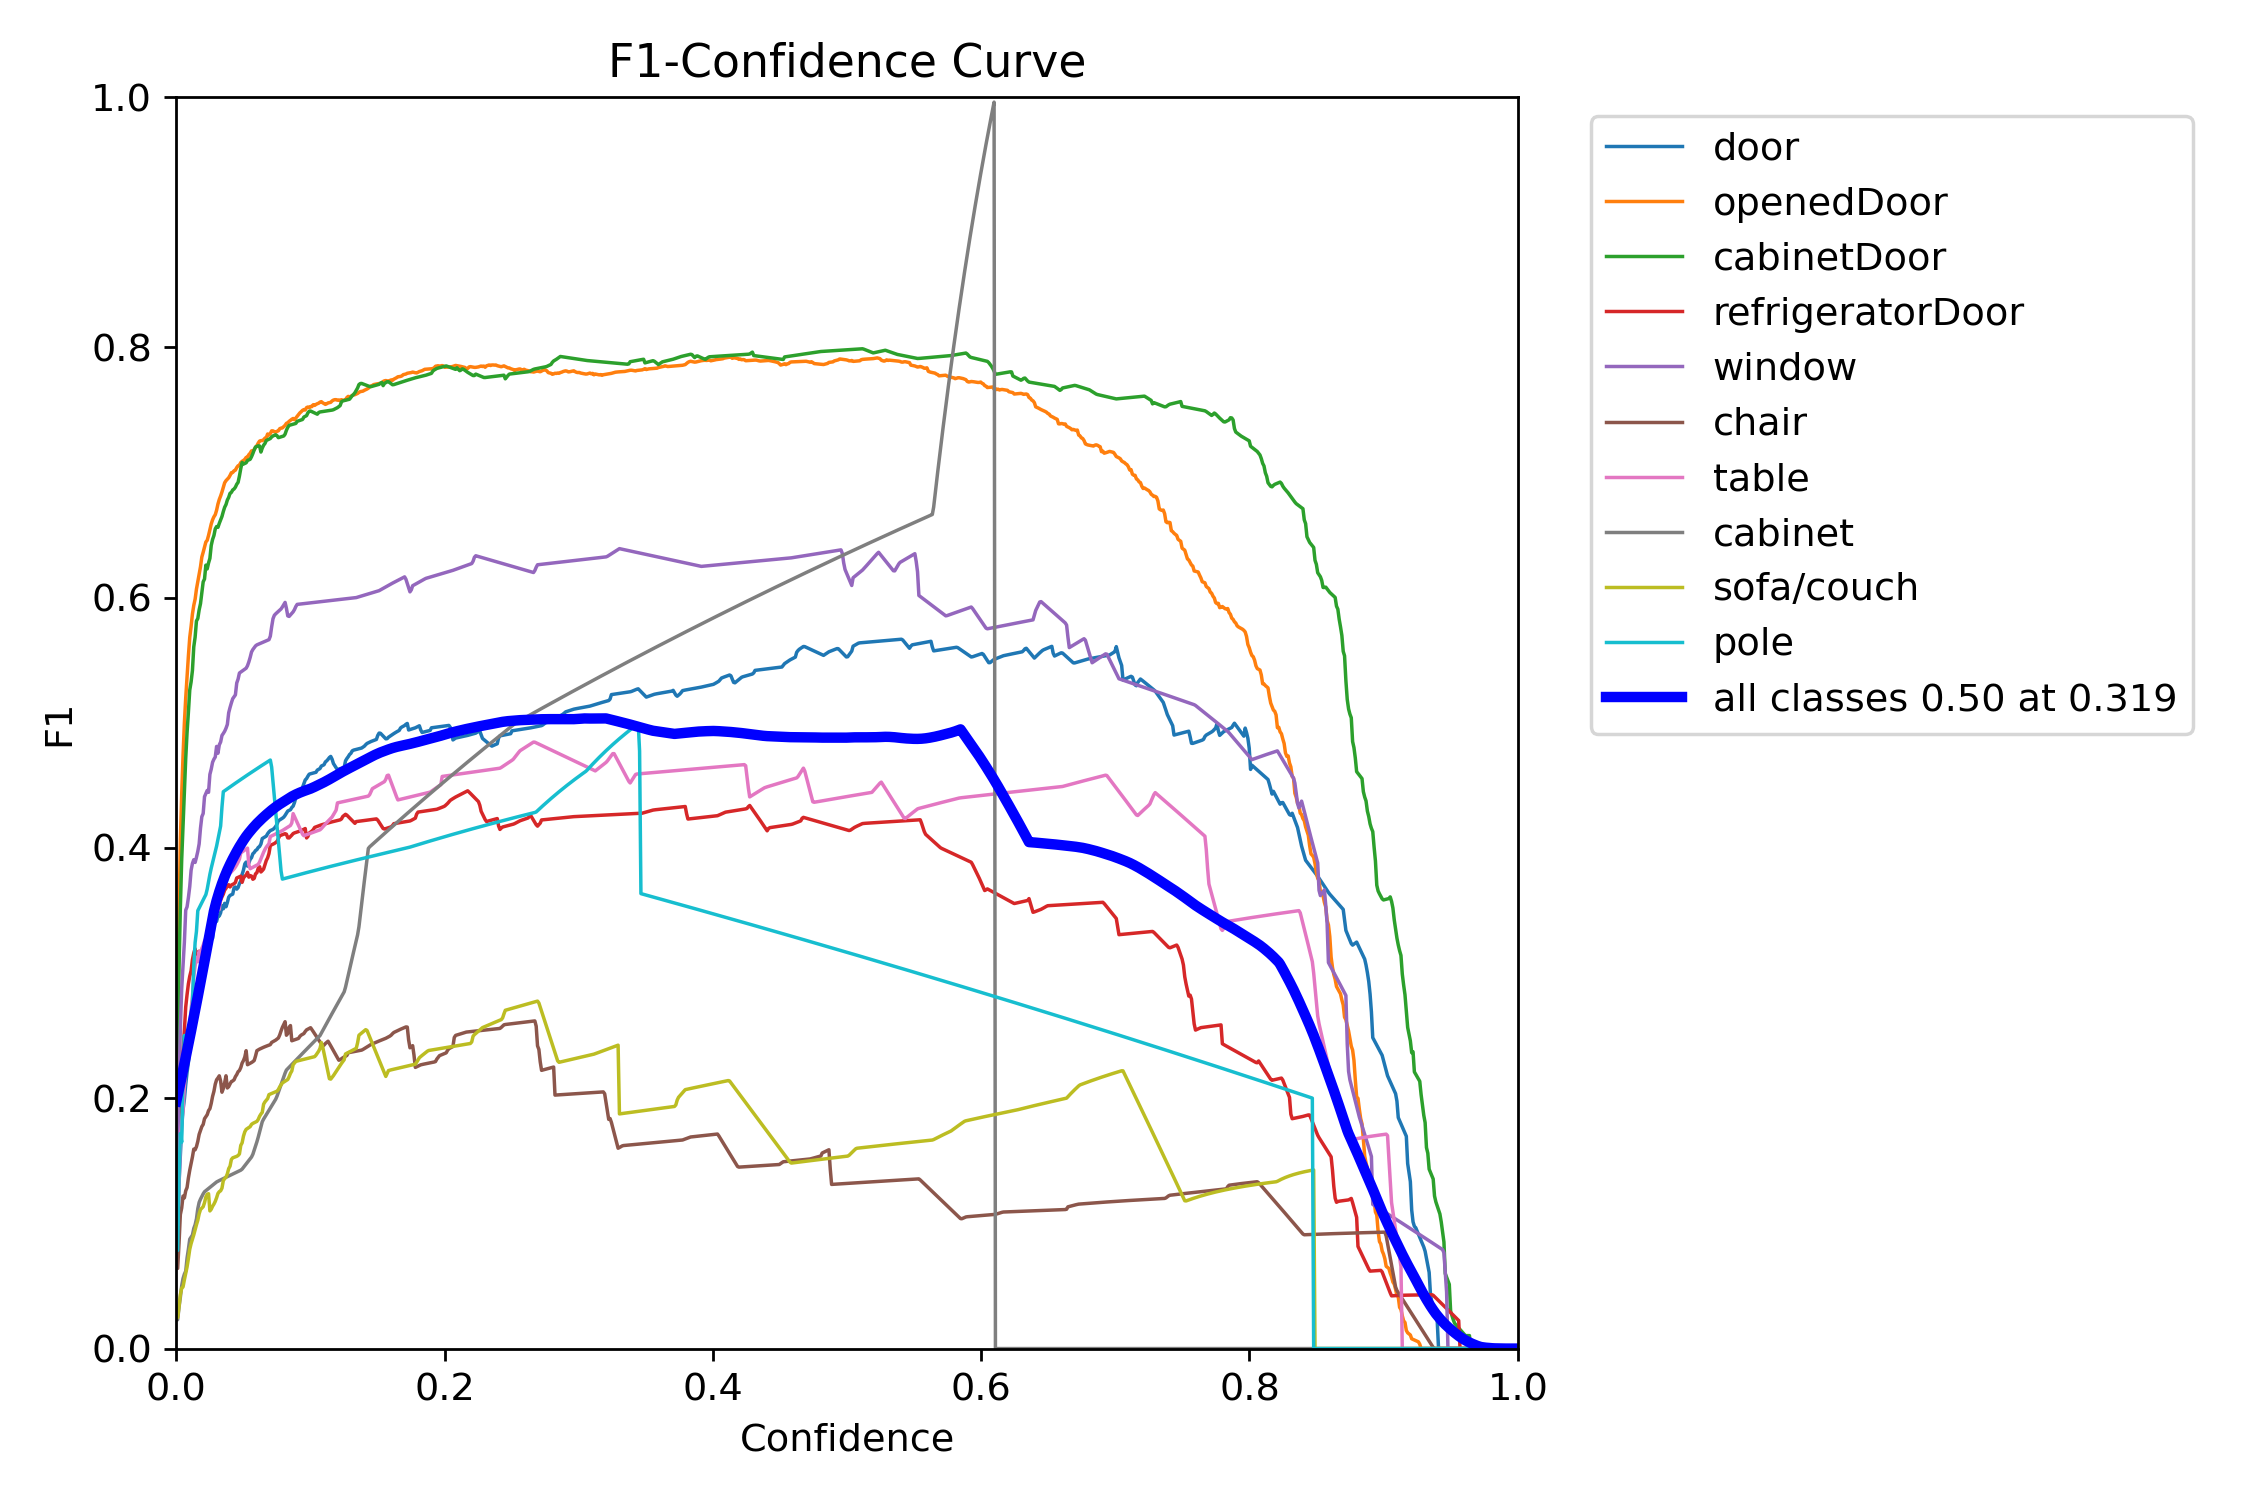



/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/PR_curve.png


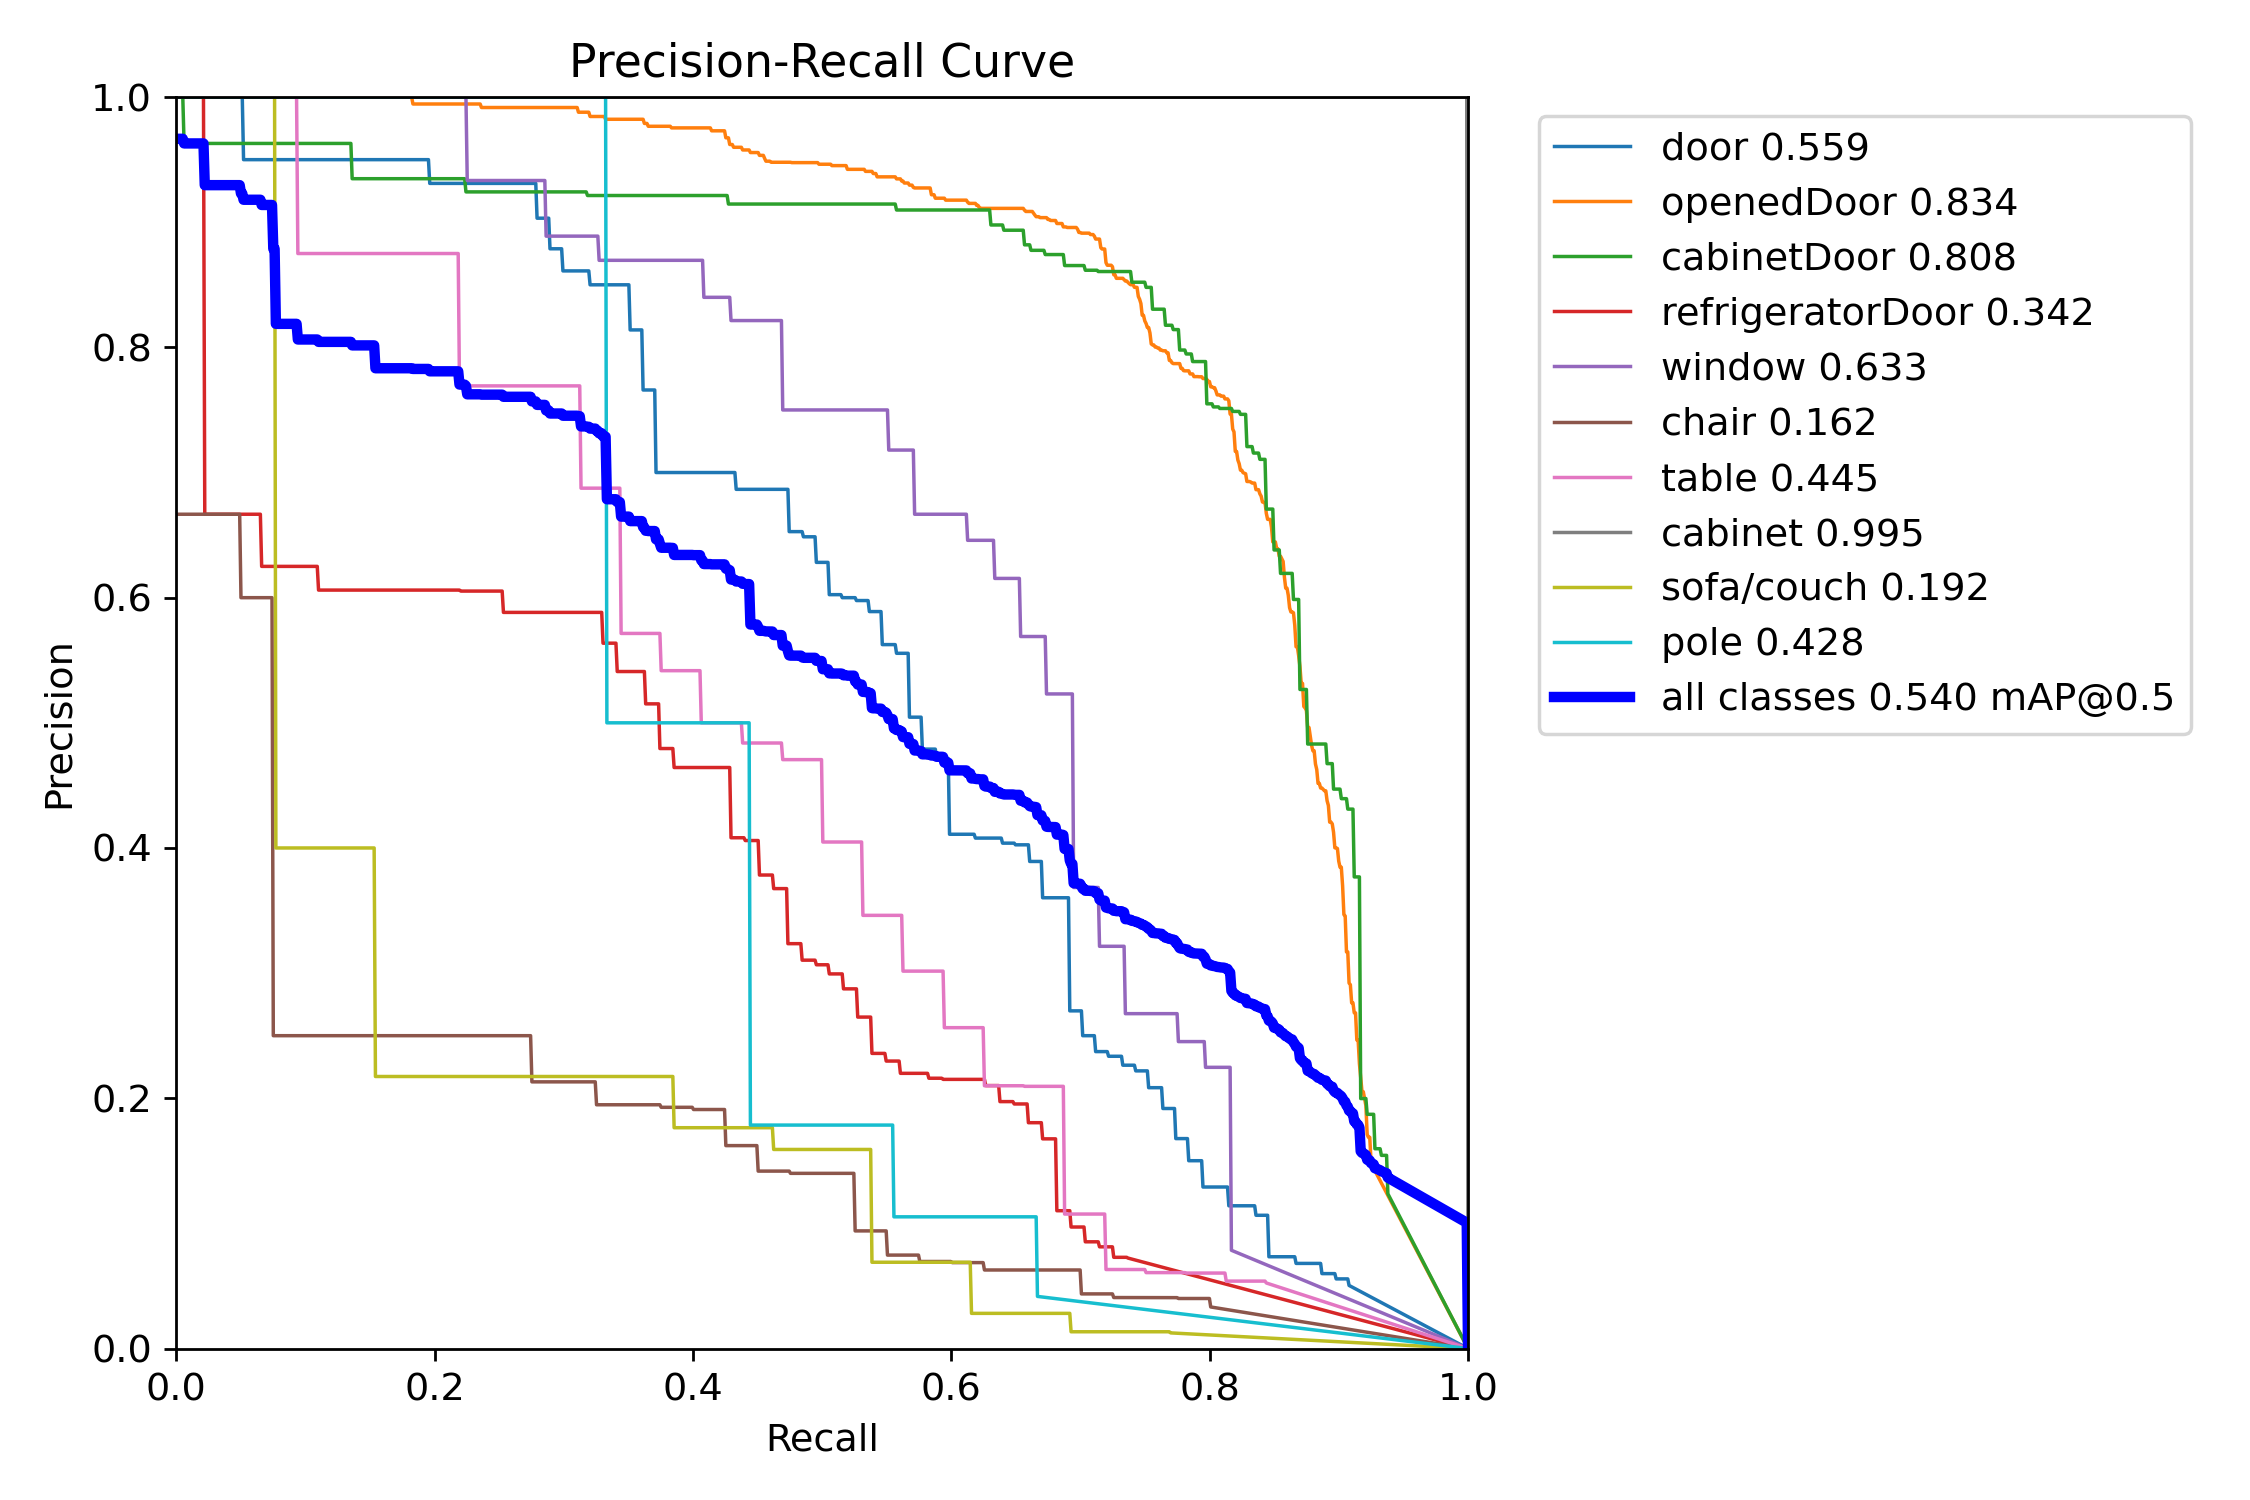



/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/P_curve.png


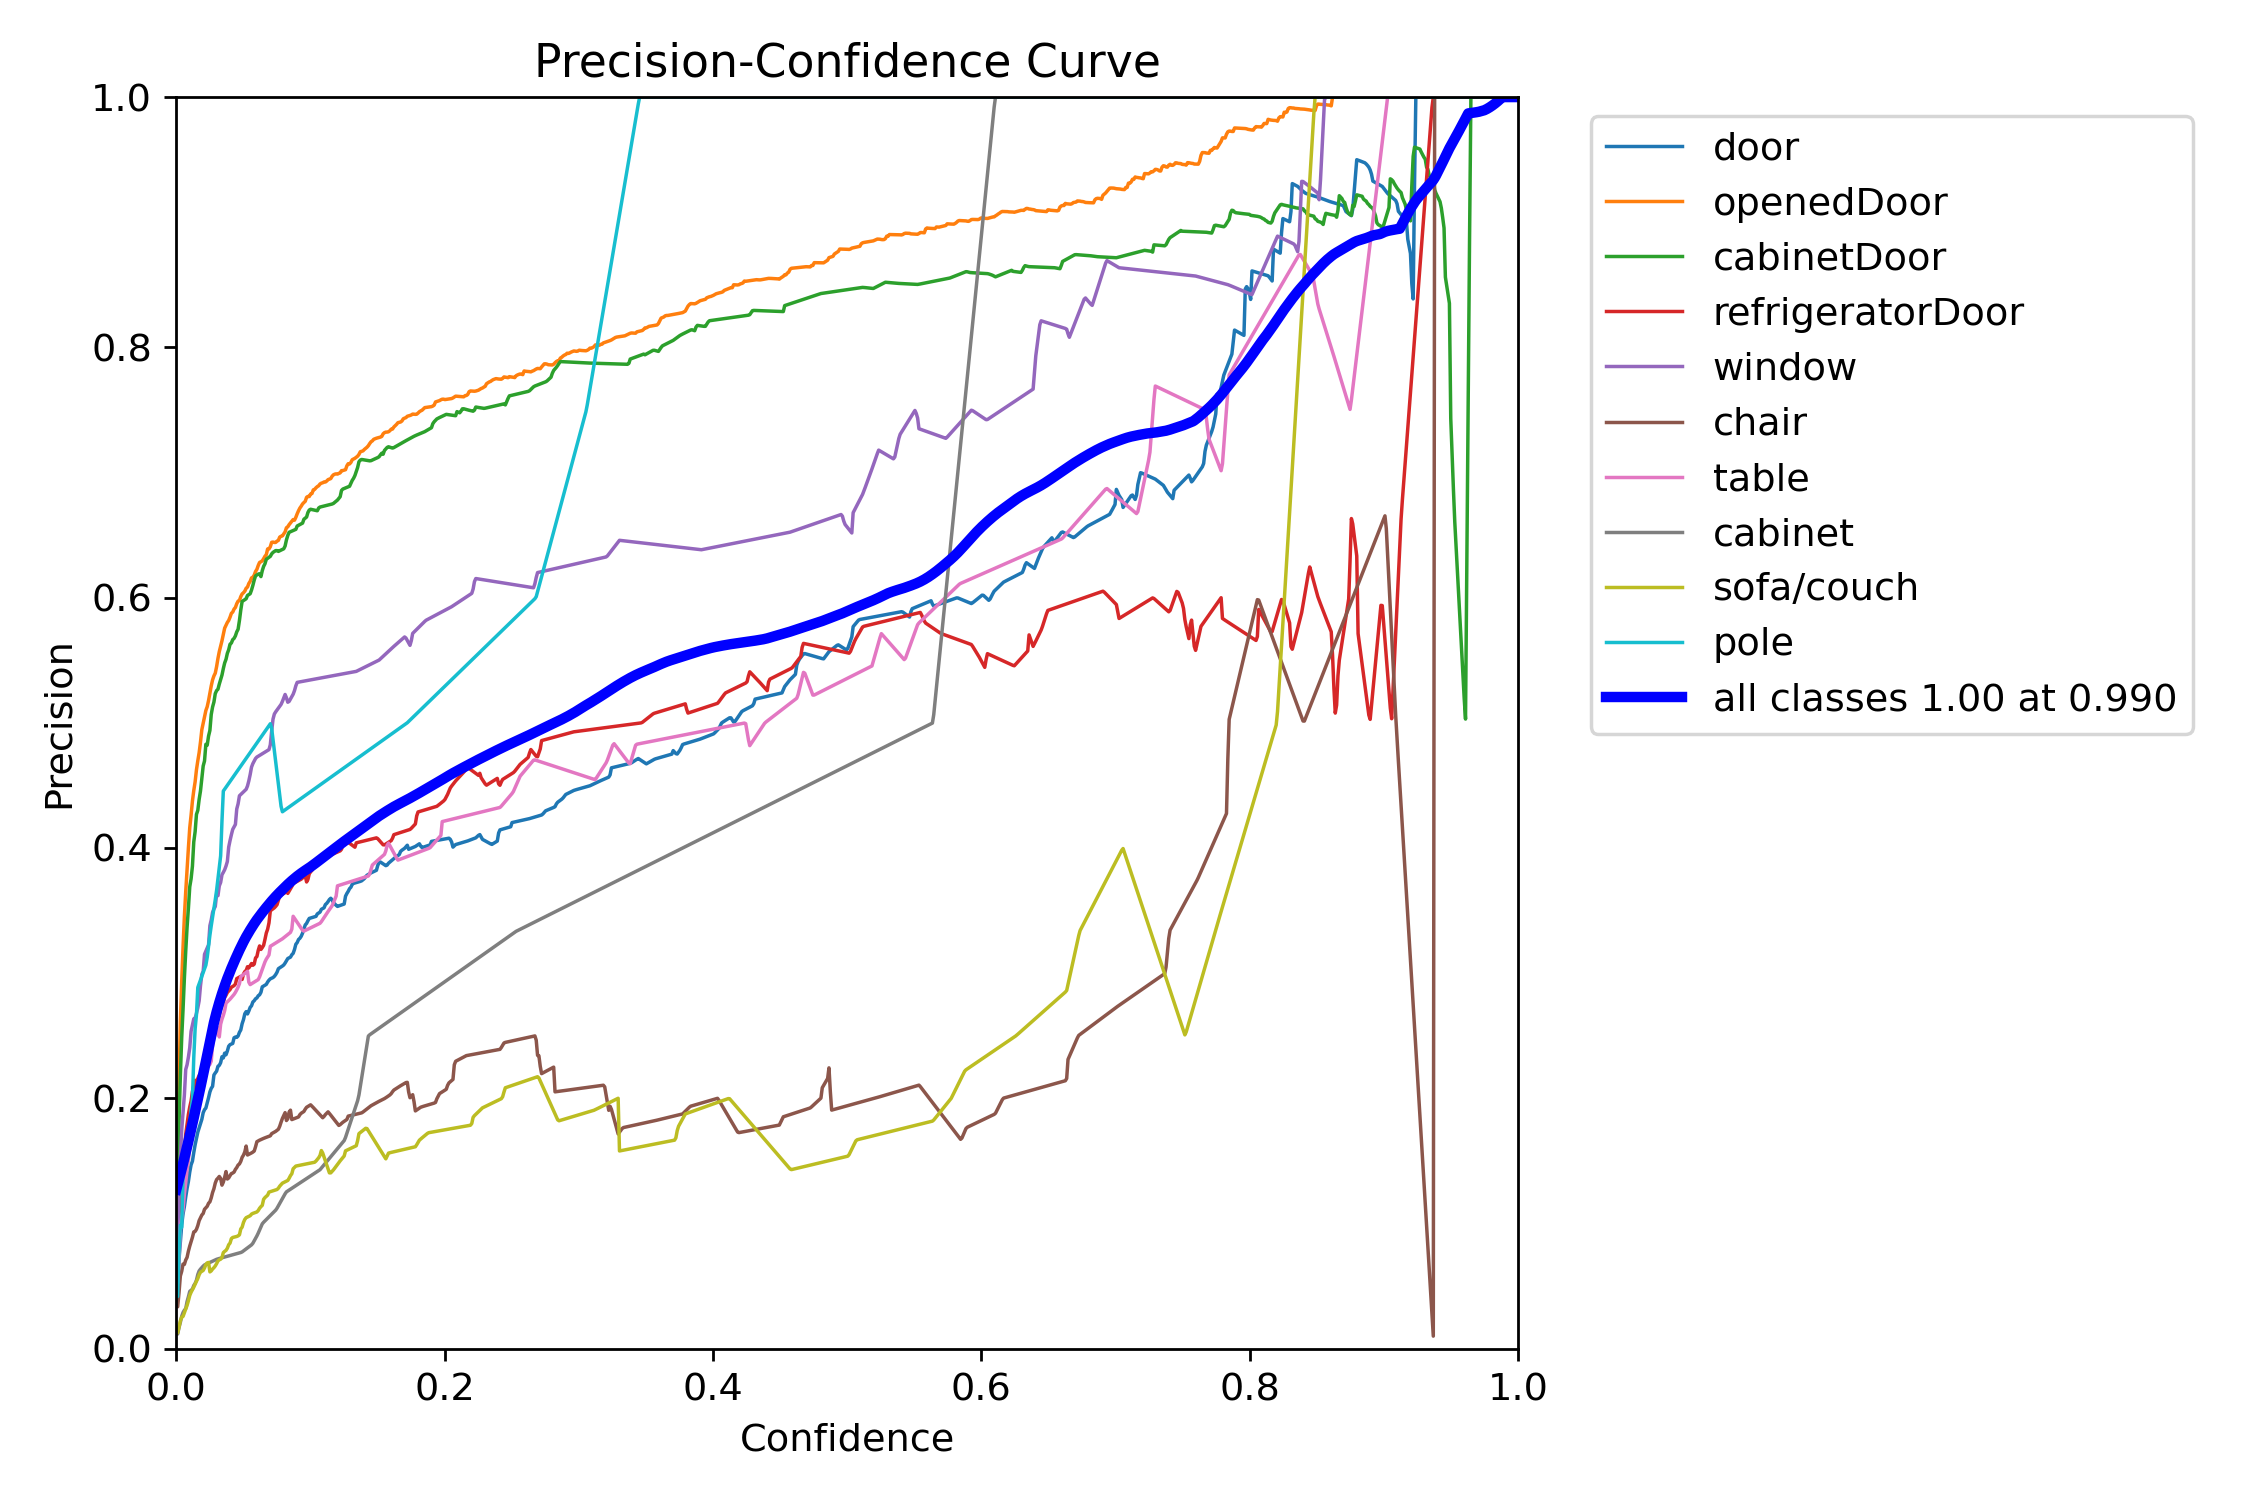



/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/R_curve.png


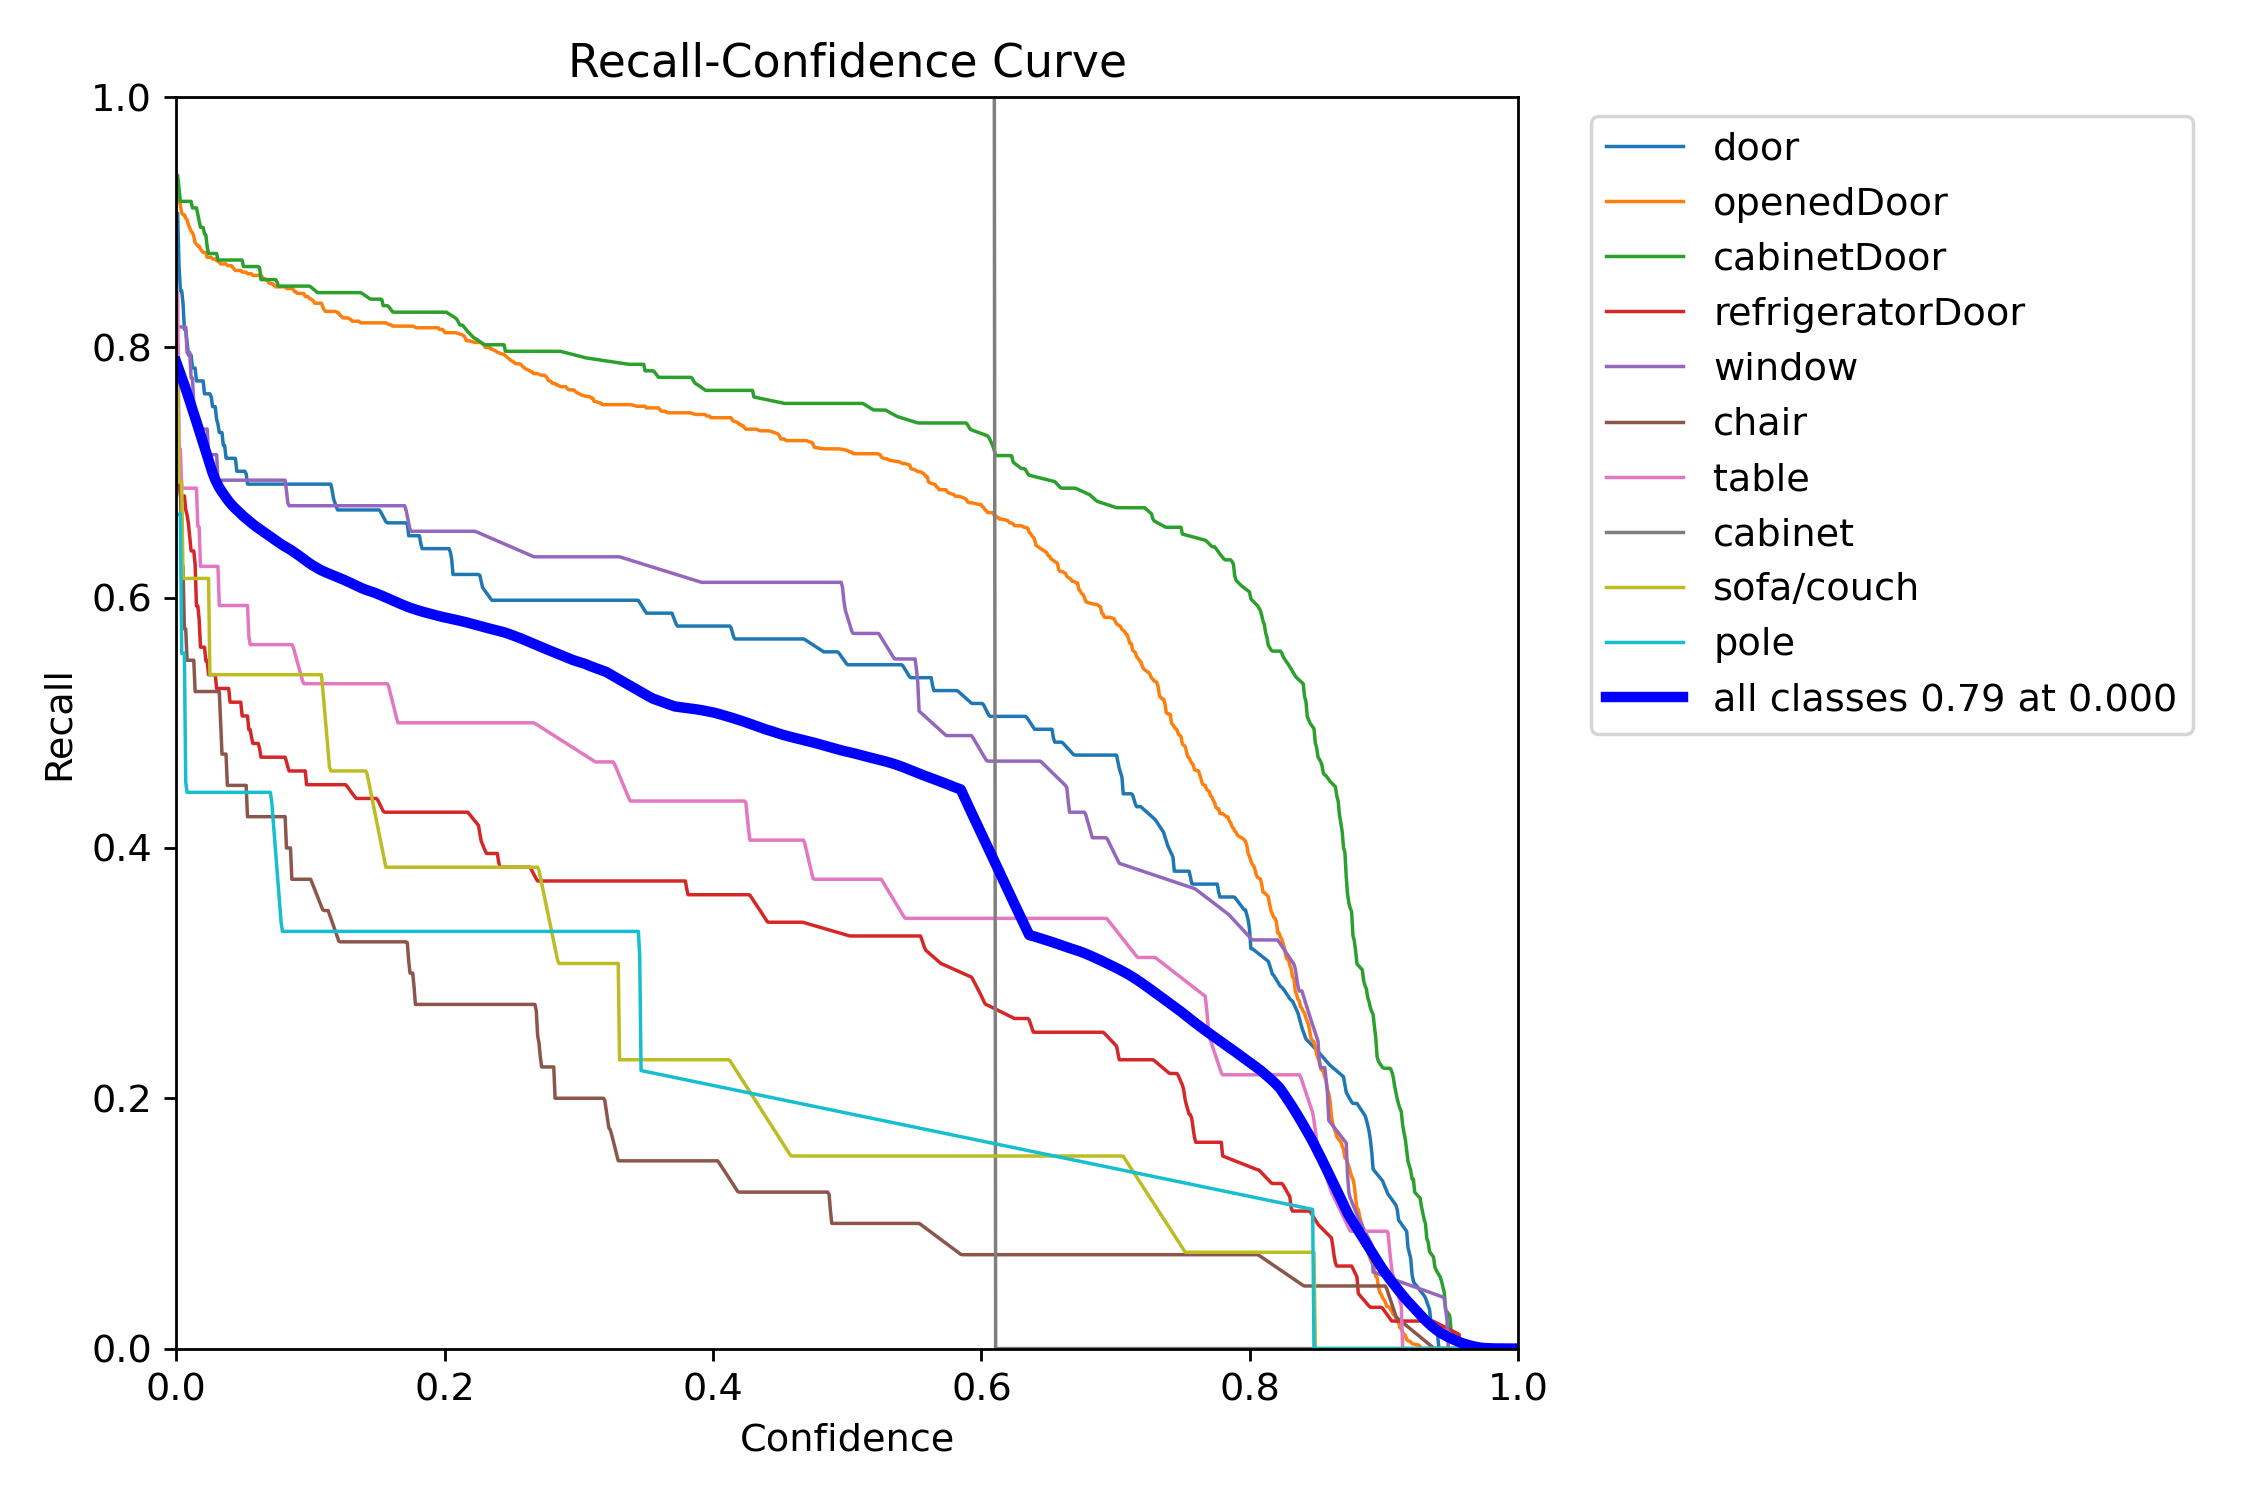



/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/confusion_matrix.png


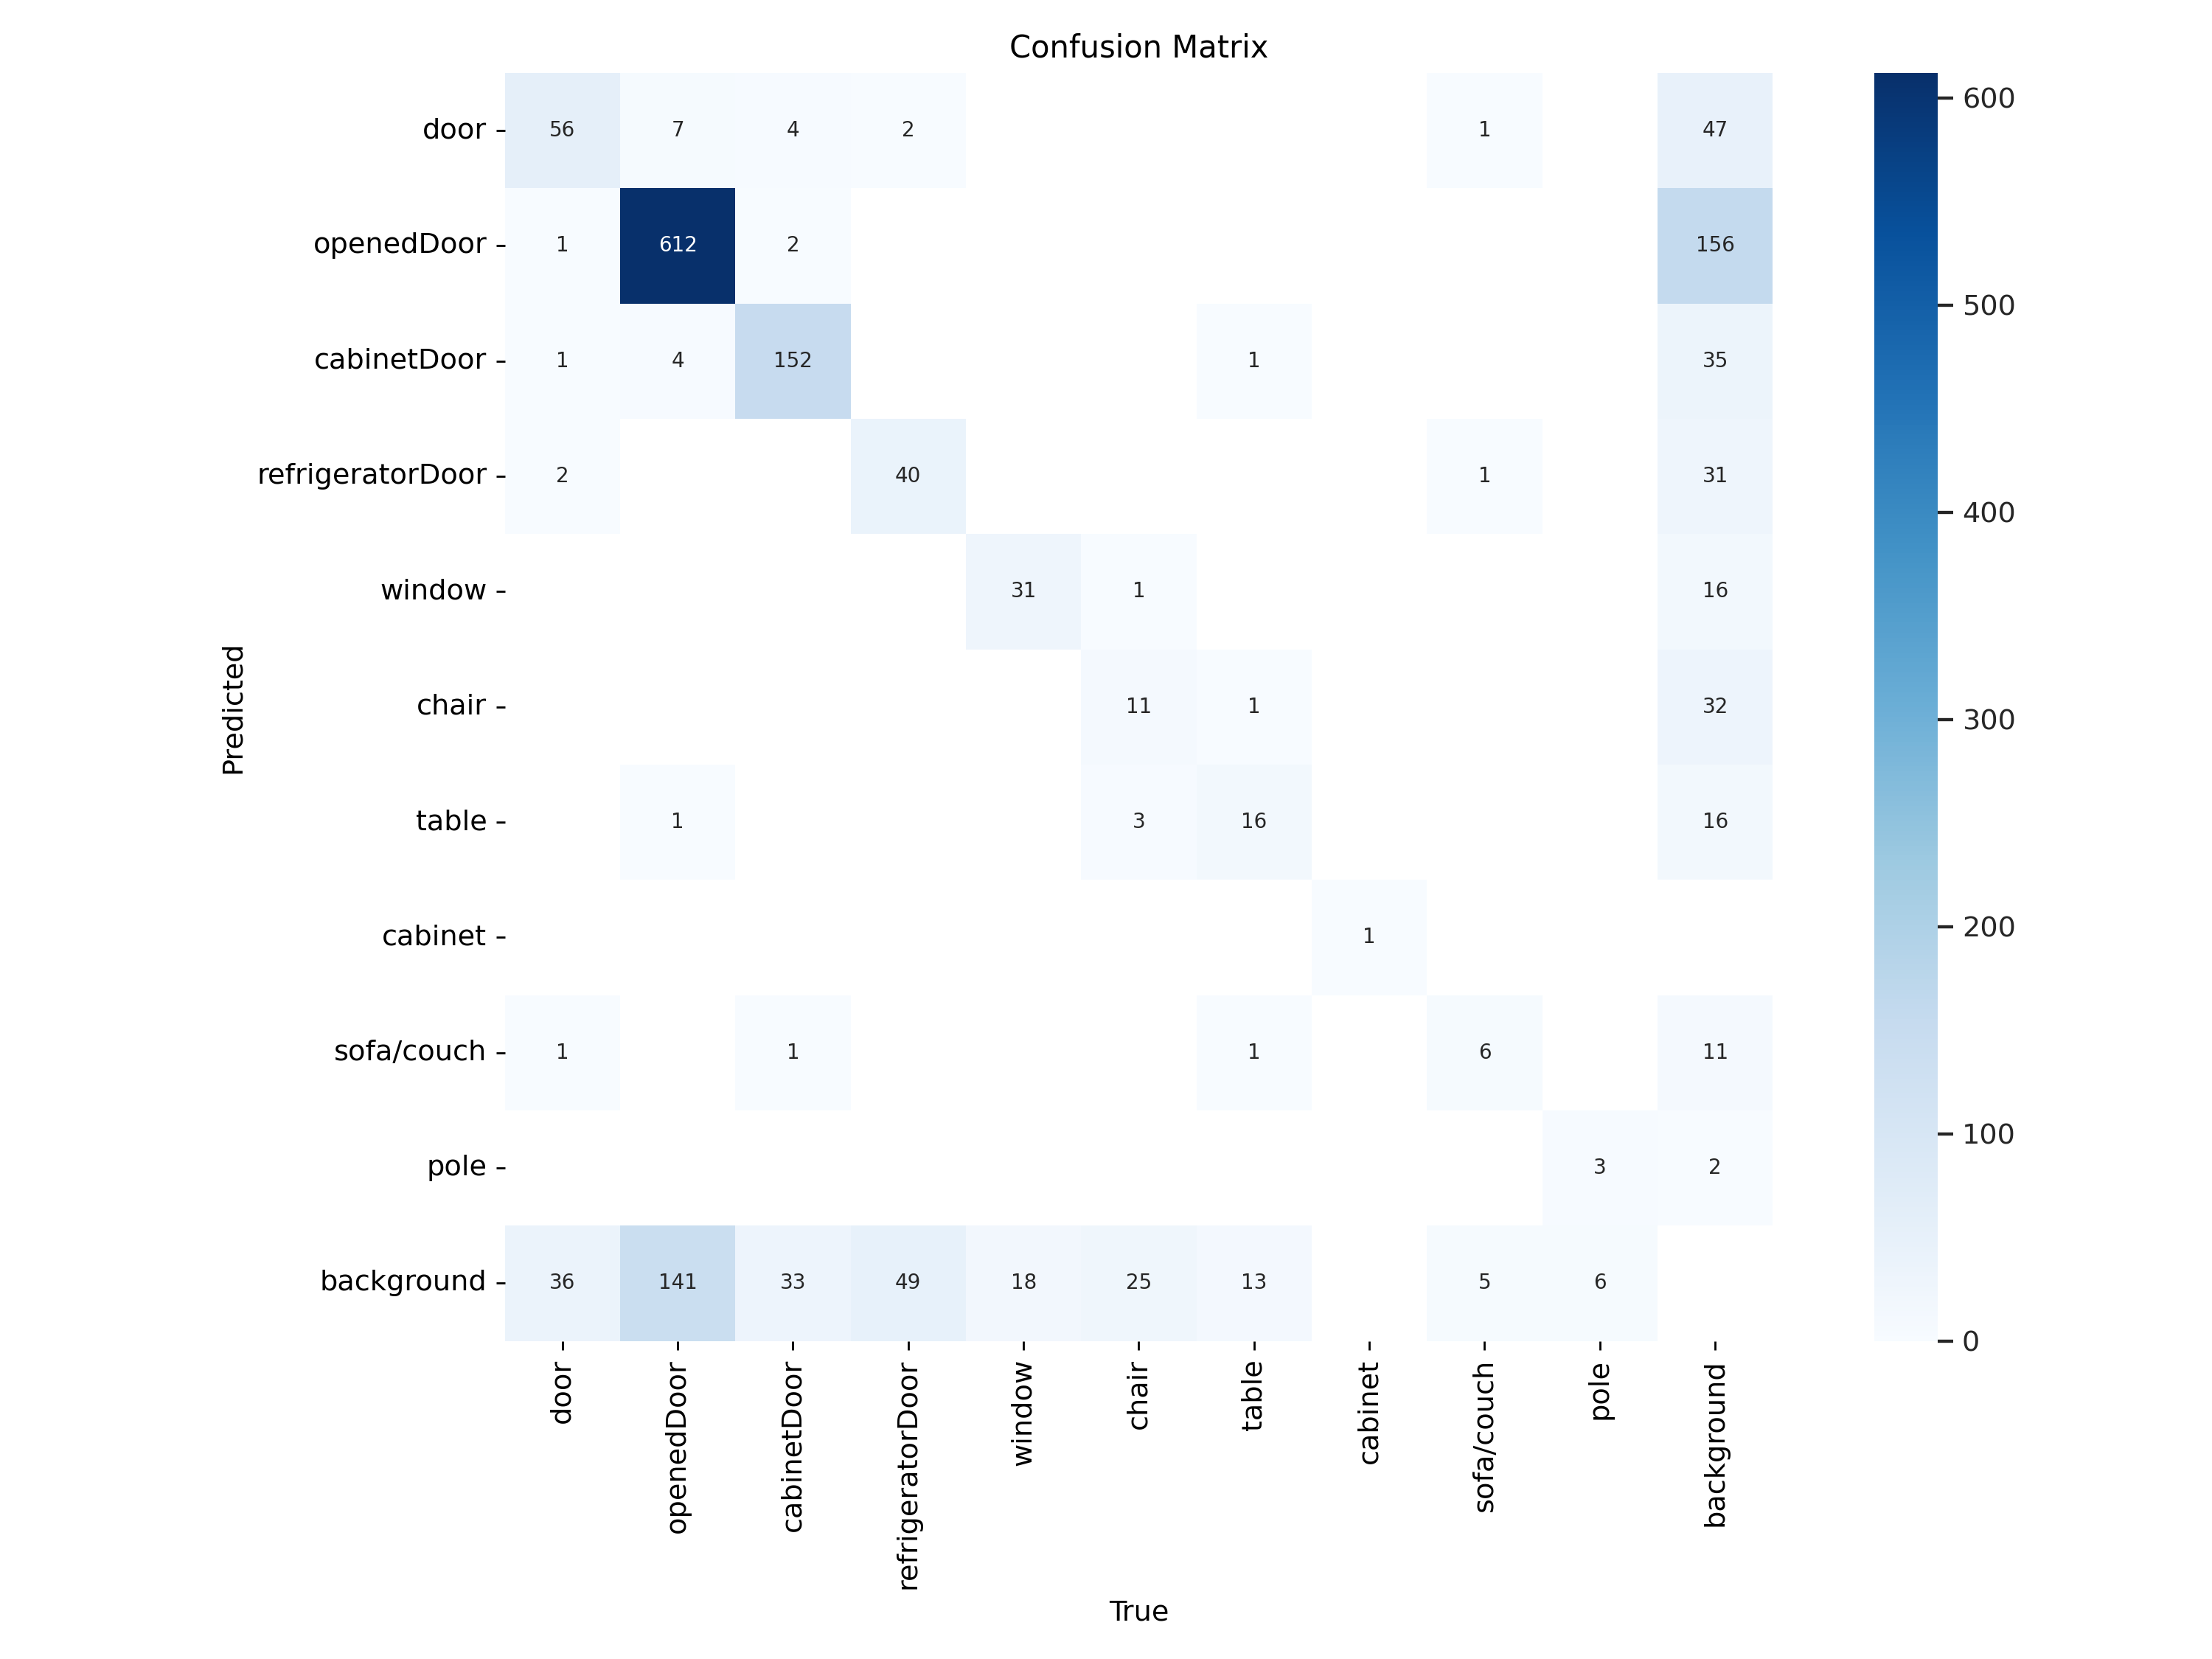



/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/confusion_matrix_normalized.png


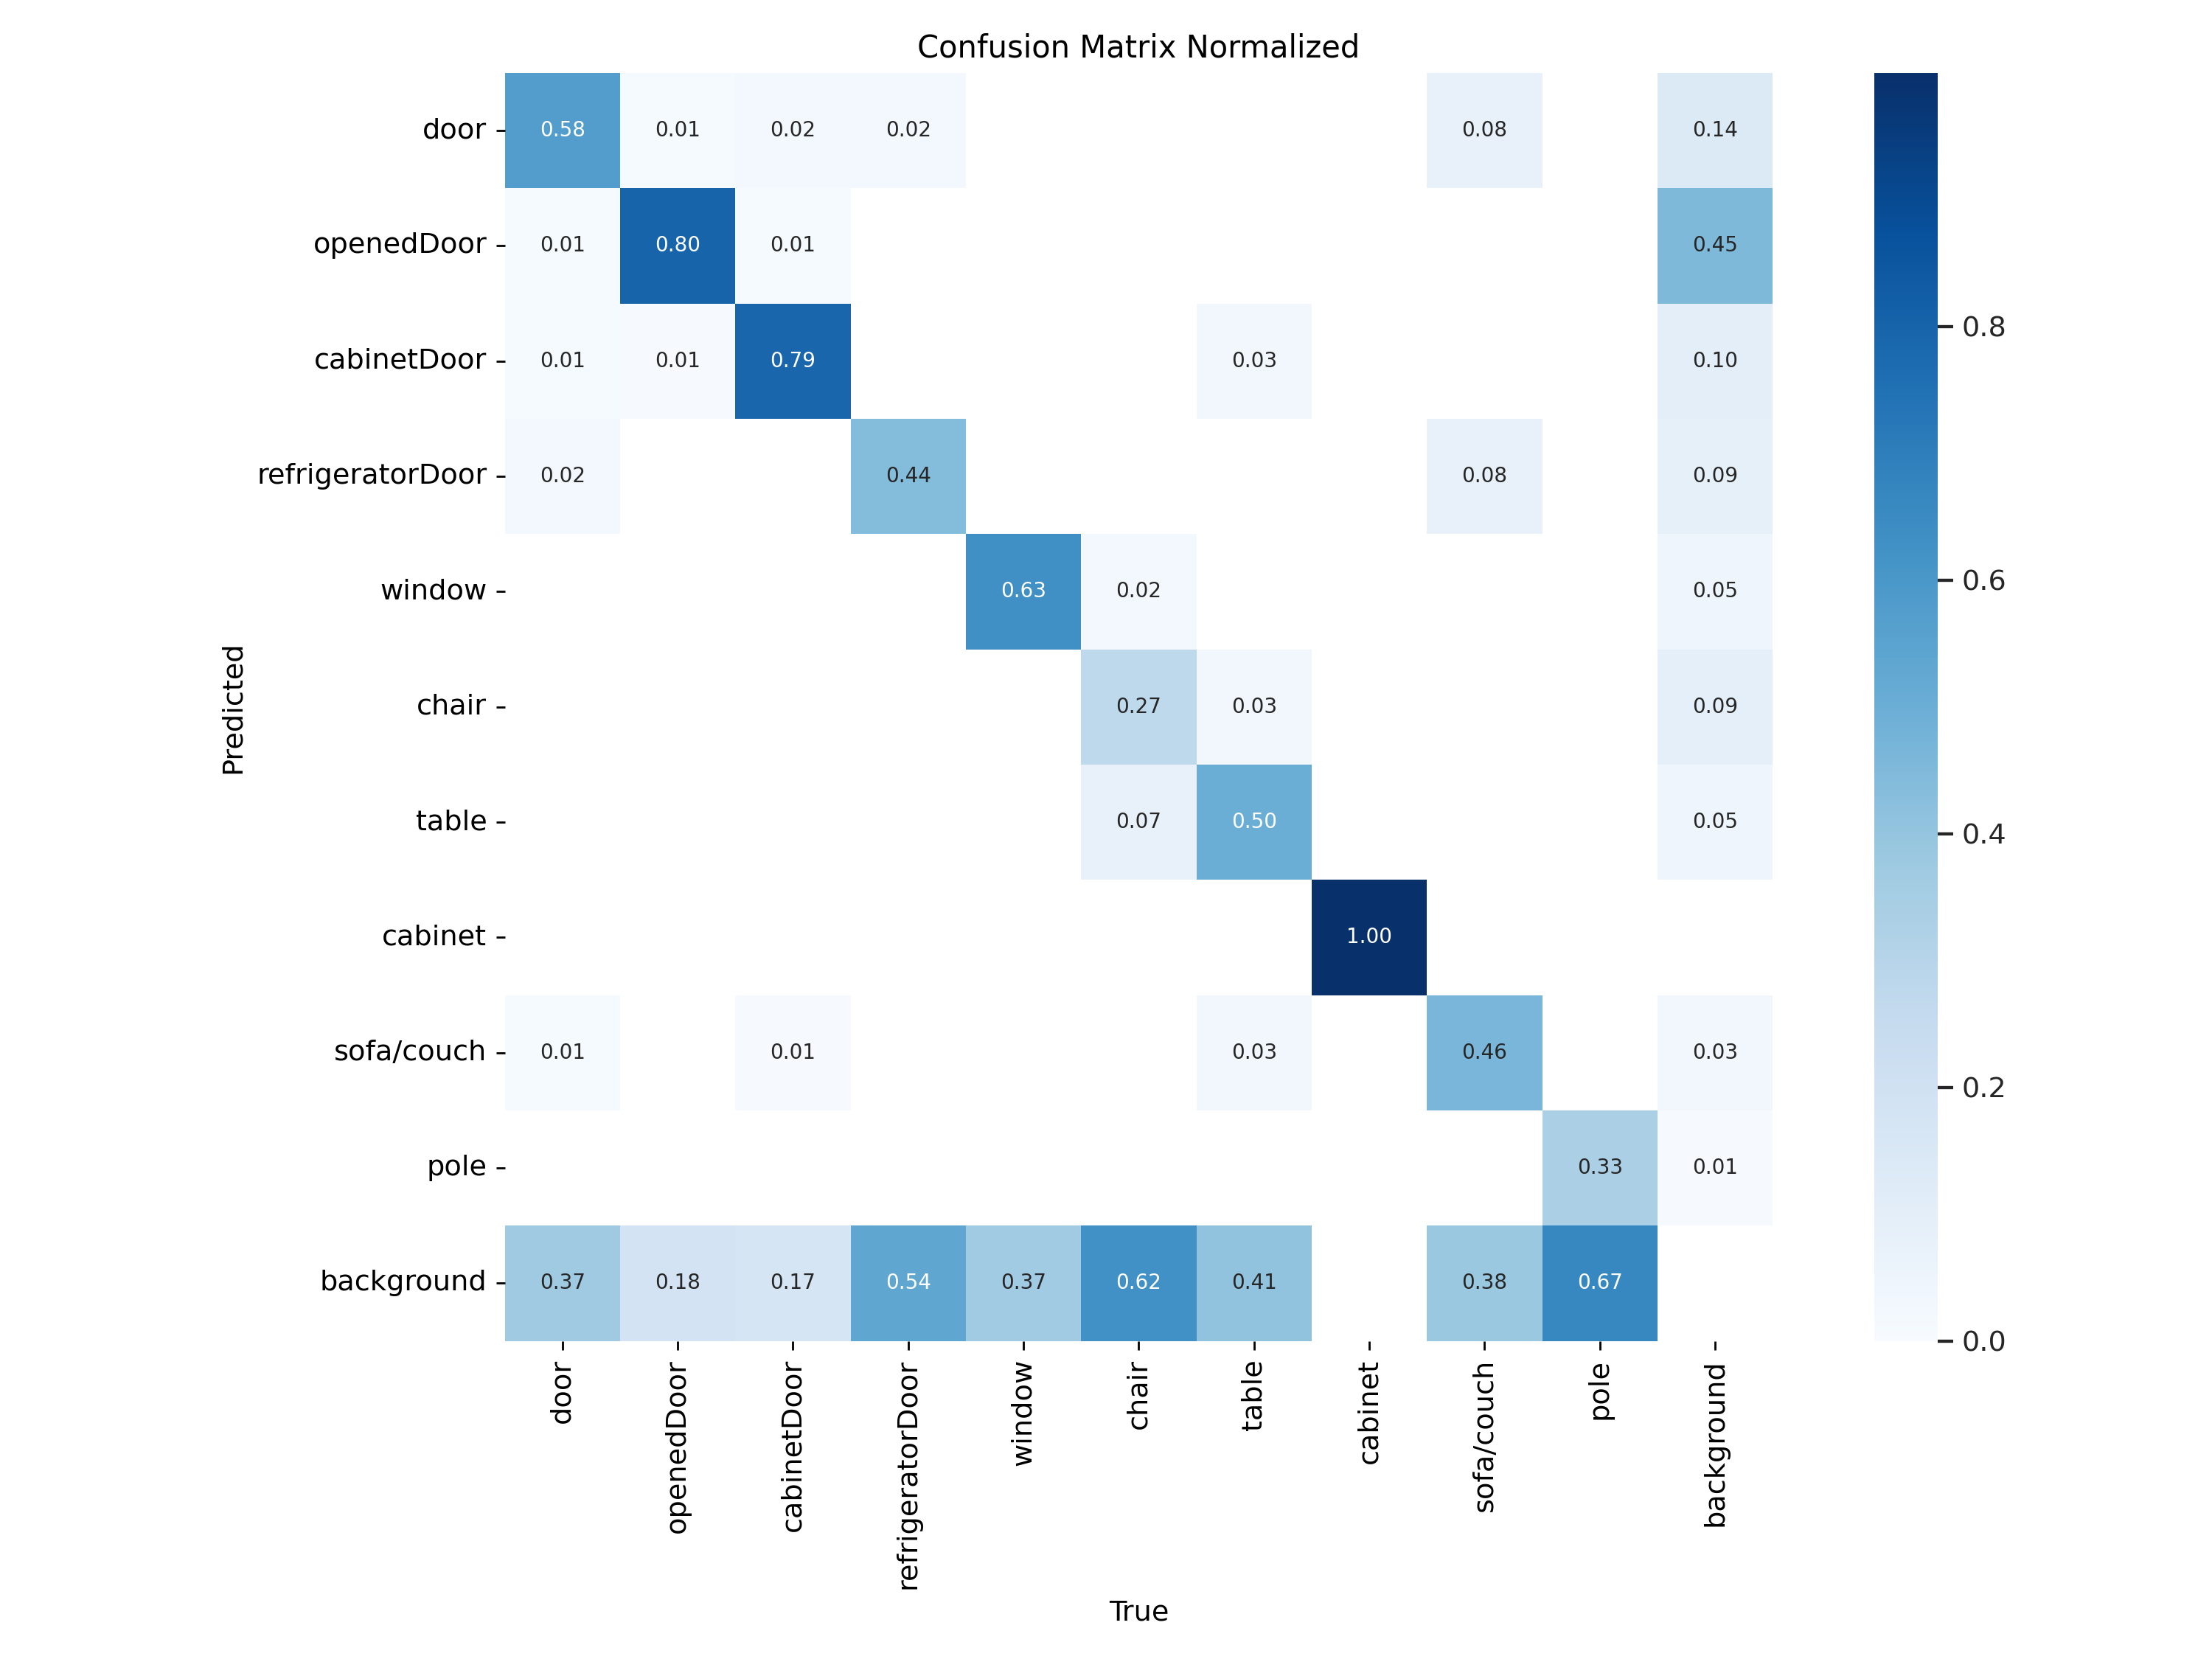



/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/labels.jpg


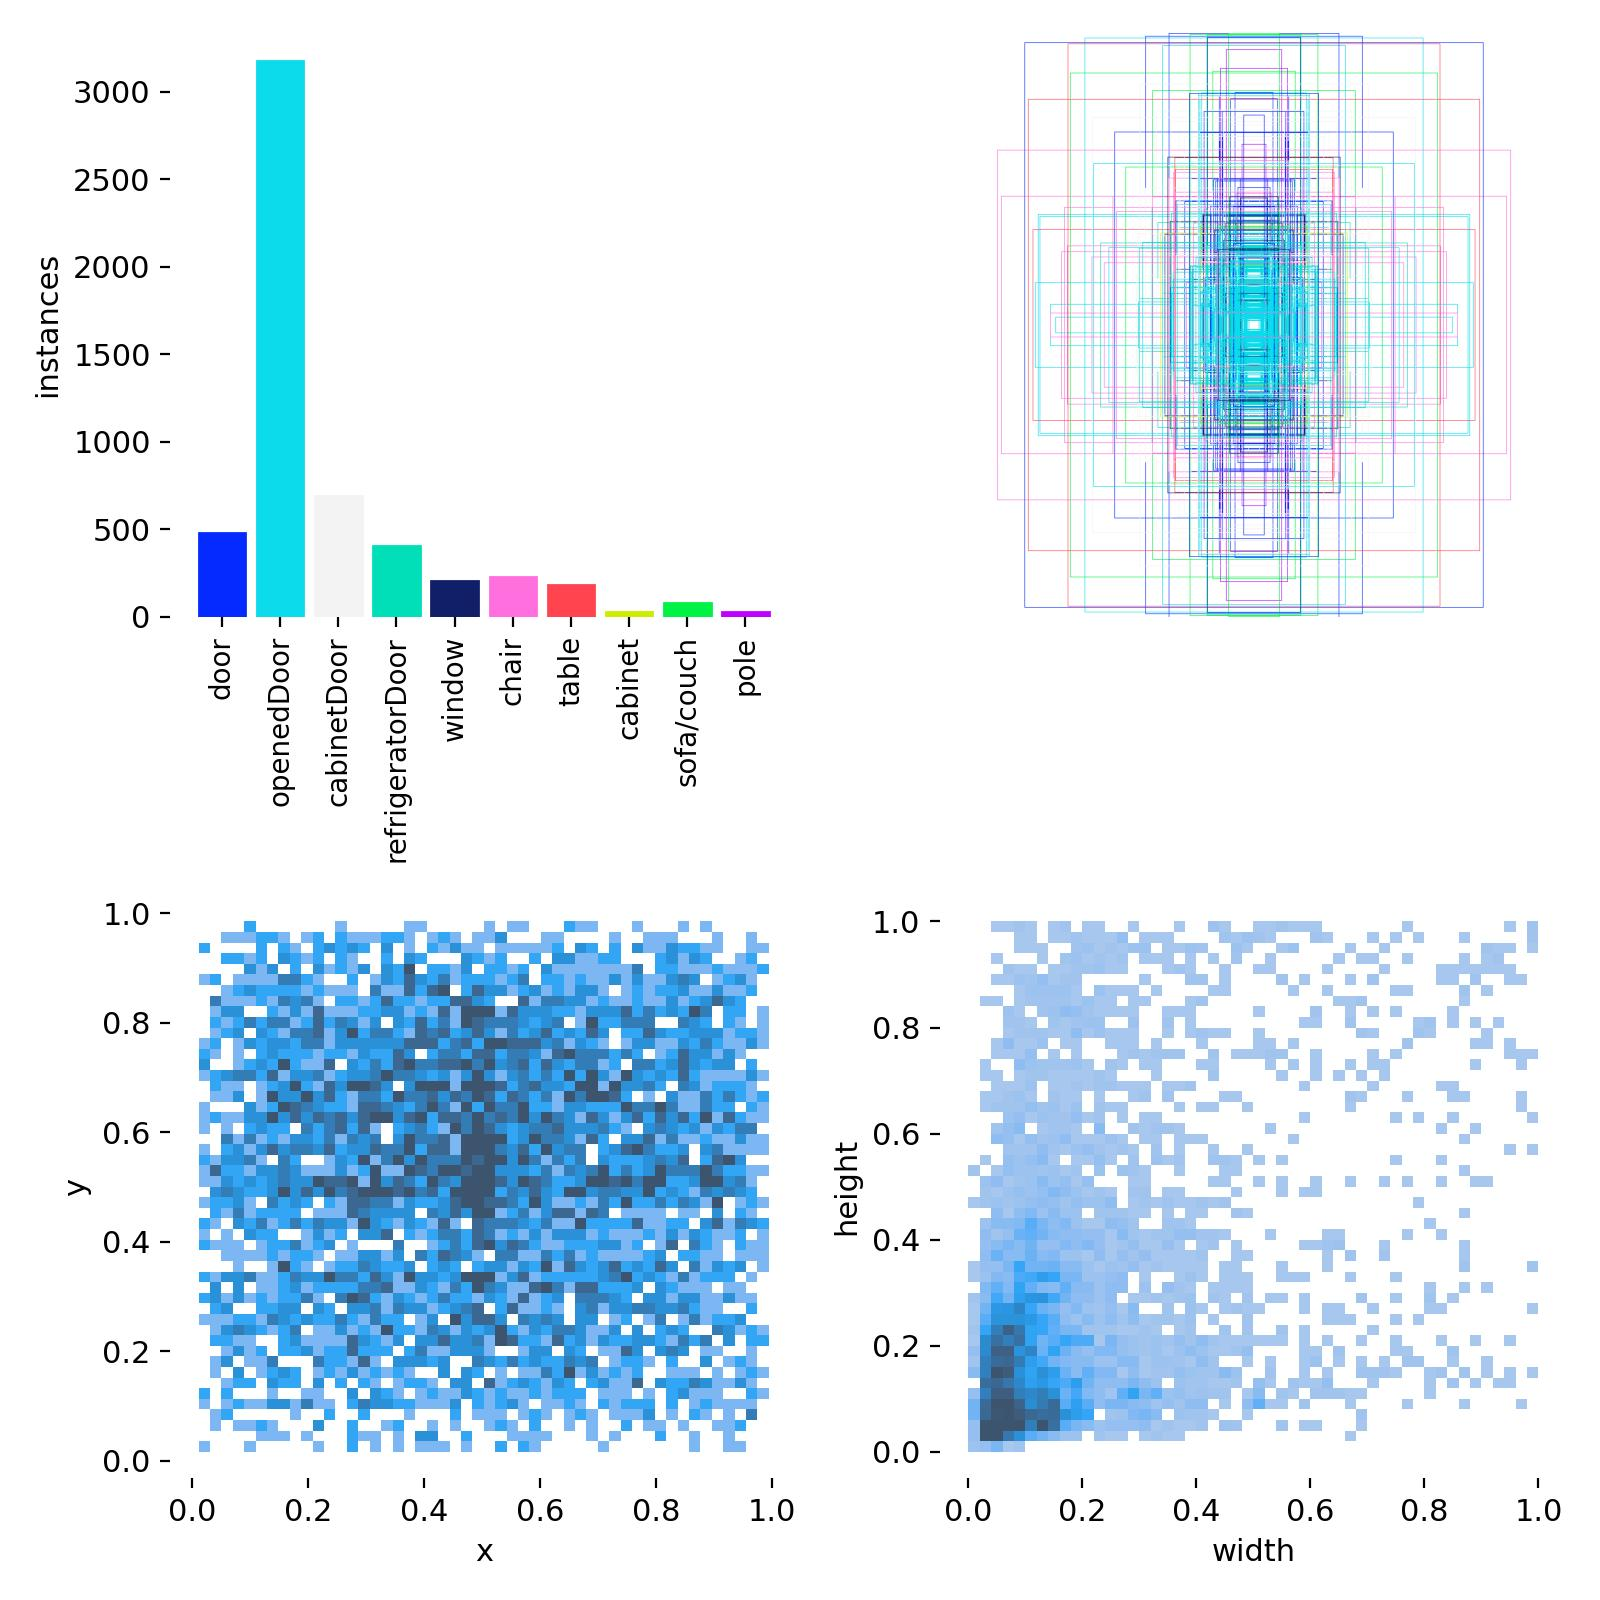



/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/labels_correlogram.jpg


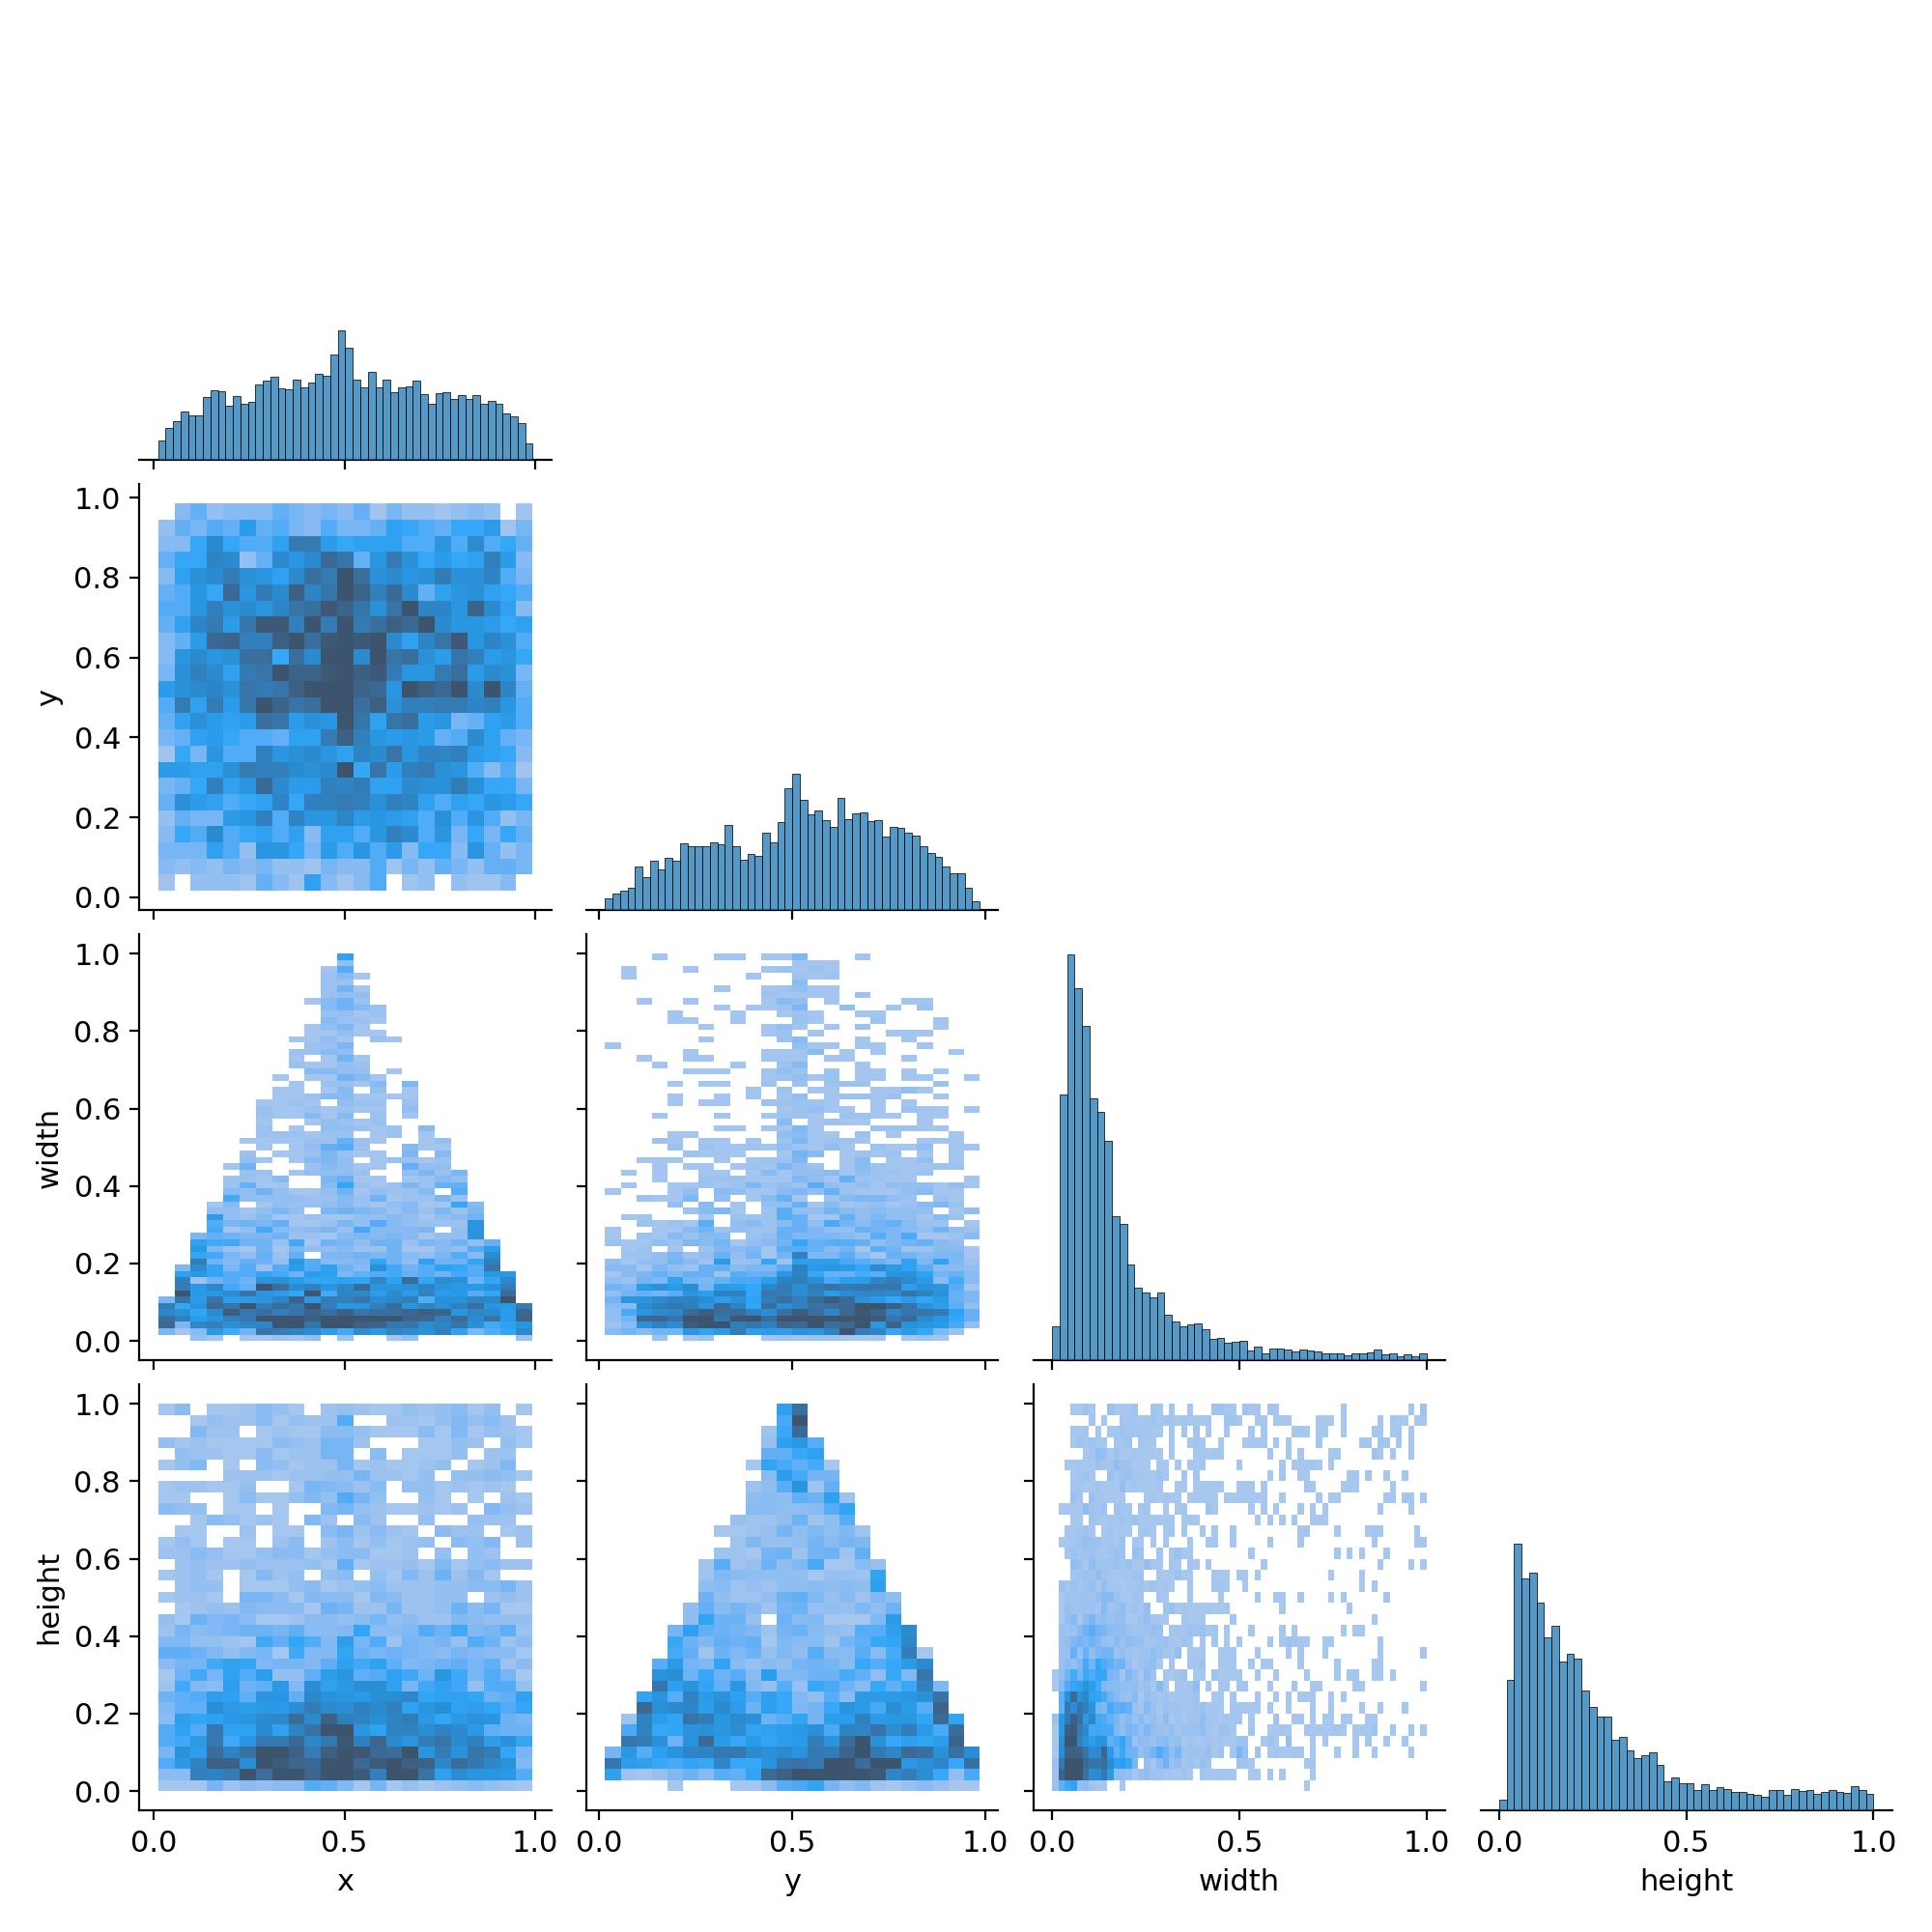



/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/results.png


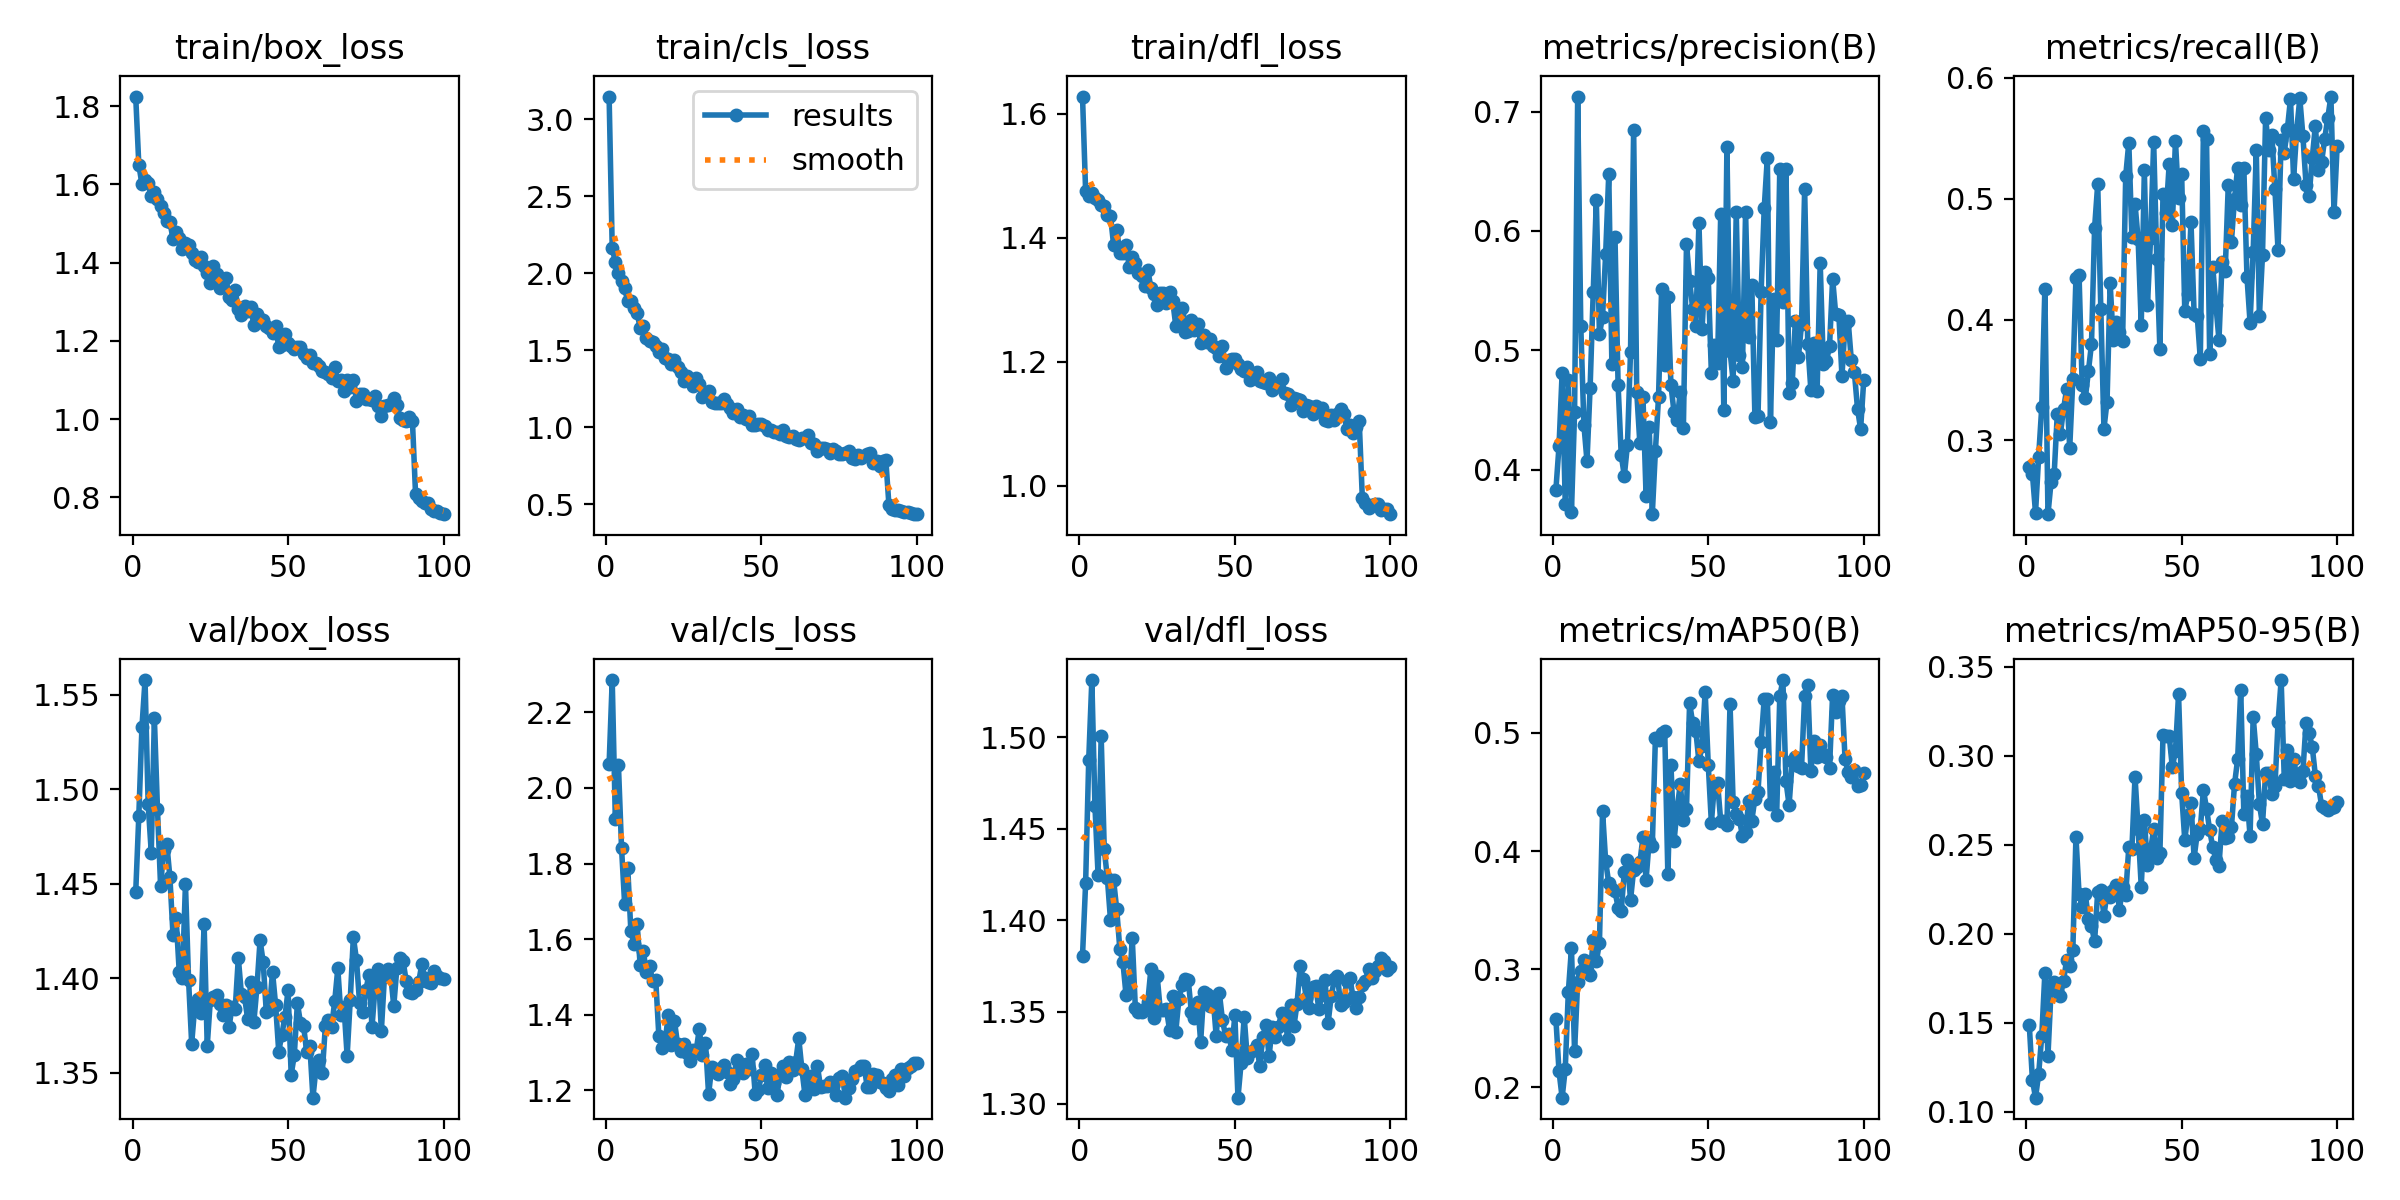

In [48]:
from IPython.display import Image, display

for file in sorted(results_paths):
    print(file)
    display(Image(filename=file))
    print('\n')

З графіків метрик точності бачимо, що модель очікувано краще навчилась виявляти ті об'єкти, що краще були репрезентовані в тренувальному наборі (opened door, ccabinet door), далі вікна, які хоч і не представлені в достатній кількості, є легшими для детекції об'єктами, і далі двері та столи. Найгірші метрики мають дивани (погано репрезентовані) та стільці (репрезентовані на рівні столів, але модель не навчилася їх розпізнавати)

З confusion matrix бачимо, що модель майже не плутає об'єкти між собою, тобто має високу класифікаційну точність, натомість плутає об'єкти з фоном (знаходить їх там, де їх немає, та пропускає ті, що дійсно існують). Проте з візуалізації результатів бачимо, що класи модель також плутає, але імовірно внаслідок неспівпадіння рамок, на confusion matrix не видно, з якими самє класами відбувається плутанина.

Показник mAР@0.50 для всіх класів склав 0.54.

In [49]:
import pandas as pd
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

epoch  train/box_loss  train/cls_loss  train/dfl_loss  \
0       1         1.82450         3.14730         1.62790   
1       2         1.65030         2.16350         1.47550   
2       3         1.60060         2.07430         1.46770   
3       4         1.61100         2.00090         1.47160   
4       5         1.60400         1.94710         1.46510   
..    ...             ...             ...             ...   
95     96         0.77011         0.45318         0.97034   
96     97         0.76455         0.44717         0.96106   
97     98         0.76606         0.44088         0.96211   
98     99         0.75926         0.44014         0.96265   
99    100         0.75731         0.43622         0.95450   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0                0.38320            0.27772           0.25784   
1                0.41968            0.27225           0.21362   
2                0.48101            0.23989           0.19136   
3                0.37139            0.28639           0.21552   
4                0.47473            0.32751           0.28109   
..                   ...                ...               ...   
95               0.49199            0.54959           0.46239   
96               0.48137            0.56693           0.46836   
97               0.45106            0.58454           0.45530   
98               0.43392            0.48868           0.45542   
99               0.47466            0.54321           0.46626   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0               0.14860        1.4455        2.0627        1.3807  0.000234   
1               0.11797        1.4861        2.2858        1.4202  0.000468   
2               0.10797        1.5328        1.9190        1.4878  0.000696   
3               0.12118        1.5579        2.0600        1.5312  0.000693   
4               0.14259        1.4924        1.8407        1.4624  0.000686   
..                  ...           ...           ...           ...       ...   
95              0.27096        1.3973        1.2387        1.3749  0.000042   
96              0.26936        1.4036        1.2580        1.3792  0.000035   
97              0.27057        1.4013        1.2632        1.3780  0.000028   
98              0.27134        1.4001        1.2729        1.3727  0.000021   
99              0.27393        1.3998        1.2723        1.3745  0.000014   

      lr/pg1    lr/pg2  
0   0.000234  0.000234  
1   0.000468  0.000468  
2   0.000696  0.000696  
3   0.000693  0.000693  
4   0.000686  0.000686  
..       ...       ...  
95  0.000042  0.000042  
96  0.000035  0.000035  
97  0.000028  0.000028  
98  0.000021  0.000021  
99  0.000014  0.000014  

[100 rows x 14 columns]

In [21]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.75731 , on epoch:  100 


Best Validation Box loss:  1.3368 , on epoch:  58 


Best Training Cls loss:  0.43622 , on epoch:  100 


Best Validation Cls loss:  1.18 , on epoch:  77 


Best Training DFL loss:  0.9545 , on epoch:  100 


Best Validation DFL loss:  1.3032 , on epoch:  51 



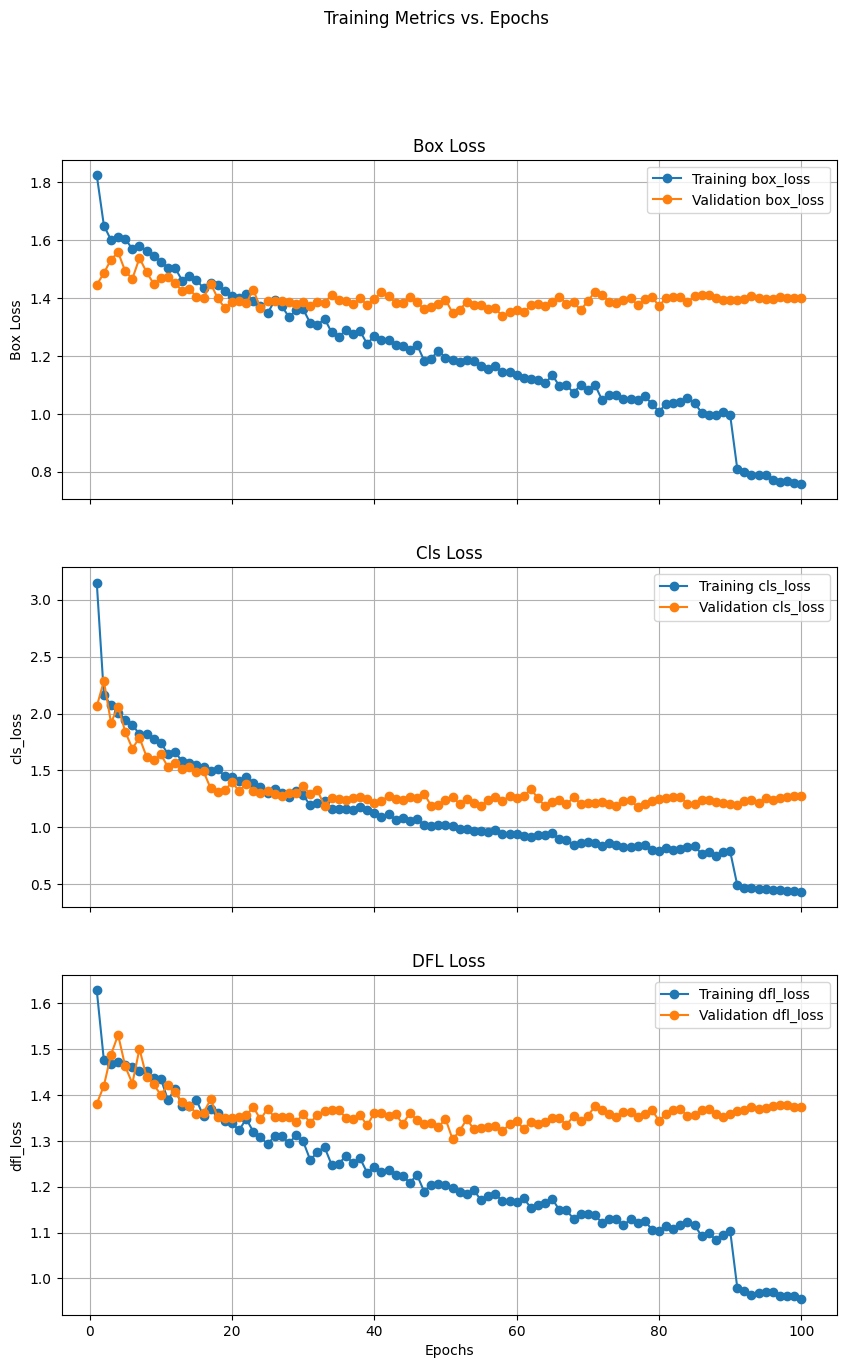

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

На графіках навчання бачимо, що попри застосовані методи проти перенавчання, модель все одне перенавчається, починаючи з 30-50 епохи в залежності від типу помилки.

In [51]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [52]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/val_batch2_pred.jpg


/kaggle/working/runs/detect/yolov8s_ppe_css_100_epochs/val_batch2_pred.jpg


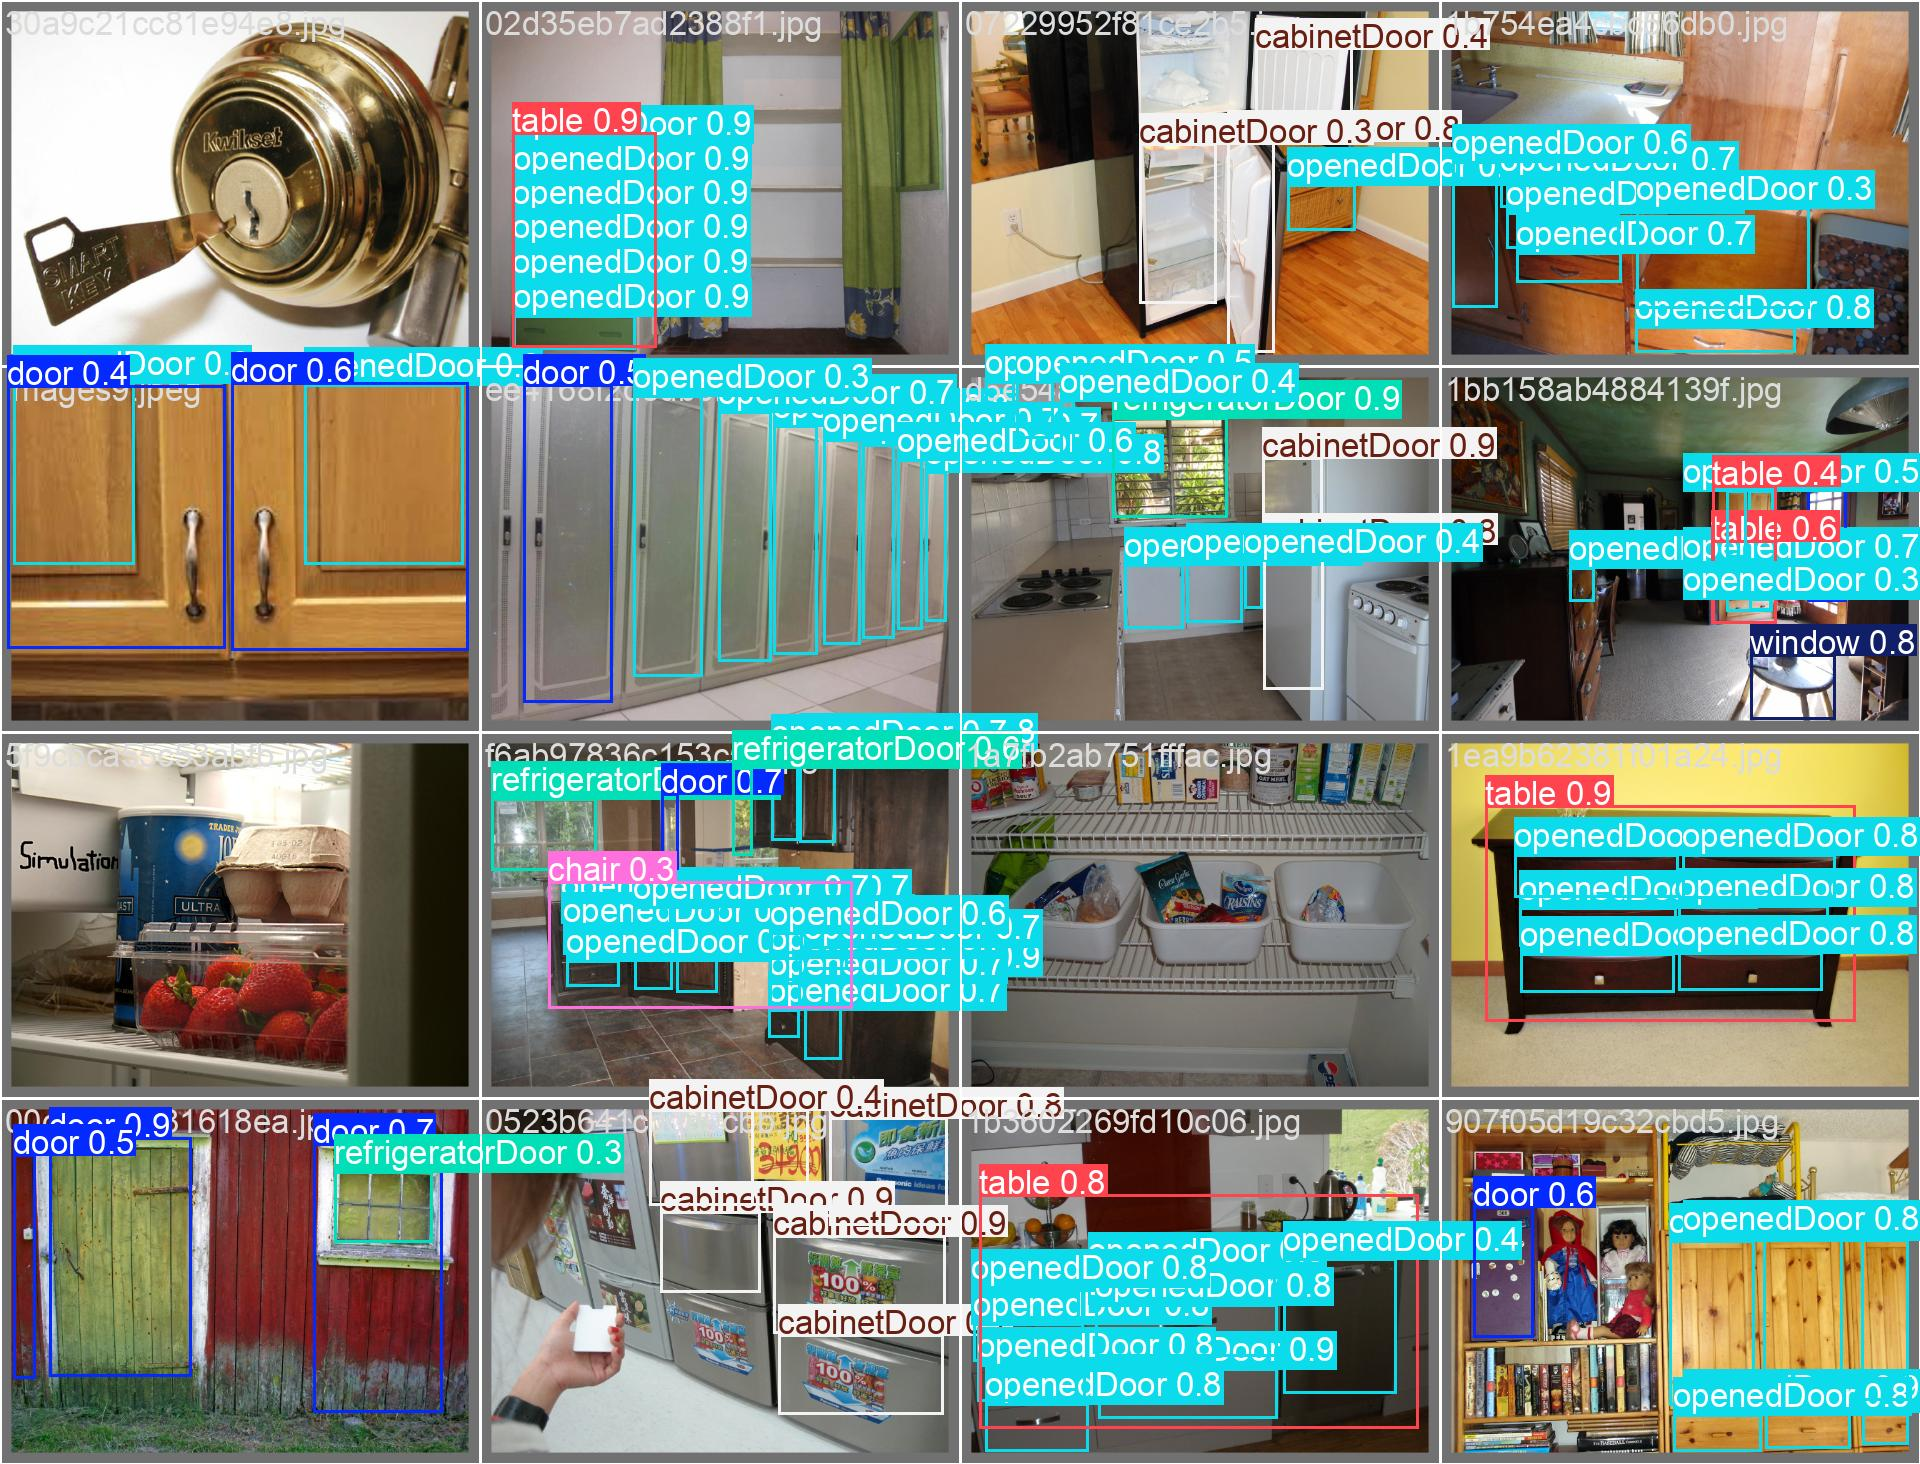

In [56]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display(Image(filename=val_img_path))


На візуалізації результатів моделі бачимо, що деякі об'єкти їй вдалося визначити, як двері. але й дуже багато неправильних міток (часто вікна модель визначає як двері холодильника, а двері холодильника як просто двері. Первіримо якість метрик на тестовому наборі, який модель не бачила під час навчання.

In [57]:
# Load the trained model
model = YOLO(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/weights/best.pt')

# Evaluate the model on the test dataset
results = model.val(
    conf=0.30,
    iou=0.50,
    data=f'{CFG.OUTPUT_DIR}data.yaml',
    split='test',
    imgsz=640,
    batch=8,
    #plots = True,
    device=0,
    #save=True,
    #save_txt=True,
    #save_json=True
)

# Get class names
class_names = results.names  # {class_id: class_name}

# Get per-class metrics
precision_per_class = results.box.p  # List of precision values per class
recall_per_class = results.box.r     # List of recall values per class
f1_per_class = results.box.f1      # List of F1-score values per class
ap50_per_class = results.box.ap50  # List of AP50 values per class
ap_per_class = results.box.ap      # List of AP50-95 values per class

# Create a list to store metrics
metrics_list = []

for idx, class_name in class_names.items():
    precision = precision_per_class[idx]
    recall = recall_per_class[idx]
    f1_score = f1_per_class[idx]
    ap50 = ap50_per_class[idx]
    ap50_95 = ap_per_class[idx]
    
    metrics_list.append({
        'Class': class_name,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score,
        'AP50': ap50,
        'AP50-95': ap50_95
    })

# Create DataFrame for convenient display
df_metrics = pd.DataFrame(metrics_list)
display(df_metrics.style.background_gradient(cmap="YlOrRd", high=0.75))

Ultralytics YOLOv8.2.98 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /kaggle/input/indoor-object-detection/test/labels... 104 images, 3 backgrounds, 0 corrupt: 100%|██████████| 107/107 [00:00<00:00, 628.79it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]


                   all        107        550      0.481      0.362      0.455      0.285
                  door         25         34      0.611      0.324      0.495       0.31
            openedDoor         42        179      0.573      0.458      0.501      0.192
           cabinetDoor          1          2      0.333          1      0.995      0.754
      refrigeratorDoor         49         63      0.682      0.476      0.593      0.414
                window         38         87      0.528      0.322      0.424       0.28
                 chair         41         47       0.31      0.277      0.276      0.146
                 table         44         52       0.44      0.212      0.356      0.285
               cabinet         31         58        0.4      0.276      0.295      0.125
            sofa/couch         18         20      0.429       0.15      0.272     0.0998
                  pole          3          8        0.5      0.125      0.344      0.241
Speed: 0.2ms preproce

Бачимо, що метрики на тестовому наборі трохи гірші, ніж на валідаційному наборі. mAP@50 для всіх класів 0.455. Серед тестових зображень модель краще ідентифікує двері холодильника, дверцята шафи, відкриті двері, двері. Проте, хоч краще всього модель може визначити дверцята шафи, такий об'єкт лише 1 раз міститься в тестовому наборі. 

## Висновки
Модель не вдалося дотренувати до досить якісних метрик. Хоча на валідаційному сеті досягнуто очікуваних резульатів за mAP@50, модель не навчилася якісно розпізнавати стільці та столи. Для покращення результатів було проекспериментовано із застосуванням різних натренованих моделей (Yolo8, Yolo9 різних розмірів), ріними batch size та learning rate, додаванням/недодаванням dropout, label smoothing. Головним обмеженням є недостатньо репрезентативні дані, задля вирішення цієї проблеми було застосовано прийоми аугментації даних(досить просунуті та вбудовані в бібліотеку Ultralytics YOLO). Також, обмеженням була кількість пам'яті GPU, доступна на платформі, тому розмір зоьражень було стиснуто до 640*640.

Для покращення метрик рекомендовано:
- експерименти з гіперпараметрами (збільшення weight decay для зменшення перенавчання, різні комбінації batch size та learning rate, кількості епох)
- застосування більшої моделі, наприклад Yolo9-l, та тренування її протягом більшої кількості епох.
- подальші експерименти з аугментацією даних (додавання шуму, транформації зображень, зміни кольорів і т.д)
- дадавання ваг для класів (більші ваги для менш представлених класів, що збільшить штраф за помилки в цих класах і змусить модель краще навчитися на даних міноритарних класів, але обрежно, бо це може зменшити точність на мажоритарних класах, а ціллю є загальне підвищення якості моделі)
- тренування на більшій кількості даних (наприклад, об'єднати валідаційний і тренувальний сети та тестувати лише на тестовому або зібрати більше даних для тренування)

